# The symmetric matter EOS from $\chi$EFT 

### Edited by: Alexandra Semposki

### Date last edited: 28 March 2024

Figures in the main text and supplementary material (SM) for (A) _How well do we know the neutron-matter equation of state at the densities inside neutron stars? A Bayesian approach with correlated uncertainties_ by [BUQEYE](https://buqeye.github.io/) members Christian Drischler, Jordan Melendez, Dick Furnstahl, and Daniel Phillips (see [[arXiv:2004.07232]](https://arxiv.org/abs/2004.07232)). Also generated are figures 13 and 14 for (B) _Quantifying uncertainties and correlations in the nuclear-matter equation of state_ by the same authors (see [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805)), which show order-by-order predictions of the pressure and compressibility of symmetric nuclear matter (SNM) for $\Lambda = 500\,$MeV interactions.
The results and figures here can be easily modified and extended.

This notebook uses modules from standard Python packages, third-party packages corner and gptools, and the local nuclear_matter package (install this with the command `pip install -e .` in the root directory of the repository). 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Standard Python modules
import numpy as np
from scipy import stats
from scipy import interpolate
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import matplotlib.patches as mpatches
import pandas as pd
import time

# import source code
import sys
sys.path.append('../src')

from chiral import Chiral

import corner  # https://corner.readthedocs.io/en/latest/

# To use gptools with Python 3, clone from GitHub repository 
#   https://github.com/markchil/gptools (development version)
# and install with 'pip install .' from inside repo. 
import gptools   # https://gptools.readthedocs.io/en/latest/

# accessing the cloned repo of nuclear-matter-convergence
sys.path.append('../nuclear-matter-convergence/')

from nuclear_matter import fermi_momentum, nuclear_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov
from nuclear_matter.graphs import add_top_order_legend, compute_filled_handles, plot_empirical_saturation

## Set up the defaults for figures <a id="figure_defaults"></a>

The appearance of figures can be adjusted by changing `setup_rc_params` in `nuclear_matter` or by overriding those choices here. 

In [2]:
setup_rc_params()

In [3]:
COLOR_68 = 'darkgrey'   # color for 1 sigma bands
COLOR_95 = 'lightgrey'  # color for 2 sigma bands

def curve_plus_bands_plot(ax, x, y, std, color_68=None, color_95=None, 
                          zorder=None, edgecolor=None, **kwargs):
    """
    Plot y vs. x with one sigma and two sigma bands based on std on axis ax.
     Add any other keyword pairs to style the main curve.
    """
#     if color_68 is None:
#         color_68 = COLOR_68
#     if color_95 is None:
#         color_95 = COLOR_95
    ax.plot(x, y, zorder=zorder, **kwargs)
    if color_95 is not None:
        ax.fill_between(x, y + 2*std, y - 2*std, facecolor=color_95, 
                        edgecolor=edgecolor, zorder=zorder)
    if color_68 is not None:
        ax.fill_between(x, y + std, y - std, facecolor=color_68,
                        edgecolor=edgecolor, zorder=zorder, alpha=0.7)
    return ax


## Standard Case <a id="standard_case"></a>

We have data and would like to find a function that best captures the relationship between the inputs and outputs.
A popular nonparametric tool for regression is a Gaussian process (GP).
One of the neat things about a GP is that you automatically get uncertainty quantification along with the line of best fit.
But what is less well known is that it also provides derivatives of the best fit line, and corresponding uncertainty estimates, for free!

The derivative is a linear operator, so the distributions for derivatives follow similarly to how one transforms a Gaussian random variable by scalars or matrices.
Suppose $f$ is distributed as a ($n$-dimensional, for genalizability) Gaussian random variable,
\begin{align}
    f \sim N(0, \Sigma).
\end{align}
Then for some $N\times n$ matrix $C = [1, D]^T$,
\begin{align}
    C f = \begin{bmatrix} 1 \\ D \end{bmatrix} f
    \sim N(0, C \Sigma C^T)
\end{align}
Suppose now that $D = d/dx$ and $f$ is some function of $x$, distributed as a Gaussian process:
\begin{align}
    f(x) \sim GP[0, \kappa(x, x')].
\end{align}
The above logic allows us to find how $f$ correlates with its derivative:
\begin{align}
    \begin{bmatrix} f(x) \\ f'(x) \end{bmatrix}
    & \sim GP[0, K(x, x')] \\
    K(x, x') & =
    \begin{bmatrix}
        K_{00}(x, x') & K_{01}(x, x') \\
        K_{10}(x, x') & K_{11}(x, x')
    \end{bmatrix} =
    \begin{bmatrix}
        \kappa(x, x') & \frac{d}{dx'}\kappa(x, x') \\
        \frac{d}{dx}\kappa(x, x') & \frac{d^2}{dxdx'}\kappa(x, x')
    \end{bmatrix}
\end{align}
It will be useful later to know how to add a function with its derivative, while propagating uncertainties.
For this, we will need
\begin{align}
    Af + Bf' \sim GP[0, AK_{00}A^T + BK_{11}B^T + AK_{01}B^T + BK_{10}A^T]
\end{align}



In [4]:
def draw_func_and_derivative(Xstar, kernel, X=None, y=None, err_y=None, draws=1, extra_kernel=None):
    n = Xstar.shape[0]
    XsXs = np.concatenate((Xstar, Xstar), axis=0)
    derivs = np.concatenate((np.zeros(Xstar.shape), np.ones(Xstar.shape)), axis=0)

    gp = GaussianProcess(k=kernel)
    if X is not None and y is not None:
        gp.add_data(X, y, err_y=err_y)
        gp.optimize_hyperparameters(max_tries=10)
        mean, K = gp.predict(XsXs, n=derivs, return_cov=True)
    else:
        K = gp.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)
        mean = np.zeros(2*n)
        
    if extra_kernel is not None:  # We will use this for the truncation error later
        gp_extra = GaussianProcess(k=extra_kernel)
        K += gp_extra.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)

    # The draw_sample function is much more numerically stable than
    # just using stats.multivariate_normal
    # Since we pass mean and cov, the first arguments aren't used.
    samples = gp.draw_sample(XsXs, derivs, mean=mean, cov=K, num_samp=draws)  # shape = (2n, draws)
    return samples.reshape(2, n, draws)  # separate f and f_prime by first dimension

# Nuclear Matter Application <a id="nuclear_matter"></a>

Our specific use case is similar to the example above: we fit a GP to data, in this case from a physics simulation.
But there is one additional source of uncertainty from the theory error. This will also involve us creating our own custom GP kernel!

## Import the data <a id="import_data"></a>

Choices to make here:
* Select $\Lambda = 450$ or $500\,$MeV interactions with `Lambda`. (See [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805) for details.)
* Select low or high density data by setting `high_density` to `False` or `True`.

The calculated nuclear matter data for input is in the `data` directory in csv files.

In [10]:
# class function
#density_input = np.linspace(0.05, 0.34, 300) 
density_input = np.linspace(0.05,16.4,600)
chiral = Chiral(density_input=density_input, Lambda = 500, high_density=True)

In [11]:
# class variables check
chiral.breakdown

600

Visualize the EOS.

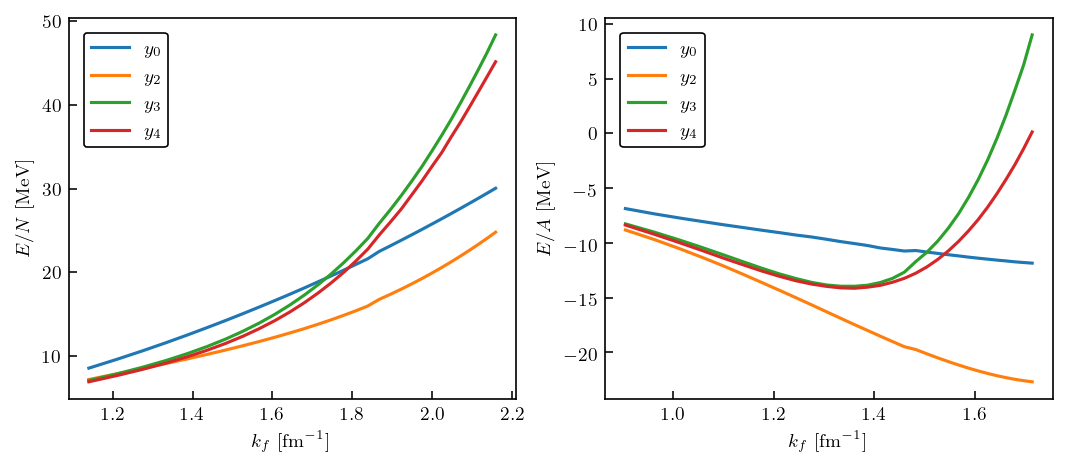

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
# fig.tight_layout(pad=2.5) 

# first neutron matter
for i, n in enumerate(chiral.orders):
    ax[0].plot(chiral.kf_n, chiral.y_n_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[0].legend()
ax[0].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[0].set_ylabel(r'$E/N$ [MeV]');

# then symmetric matter
for i, n in enumerate(chiral.orders):
    ax[1].plot(chiral.kf_s, chiral.y_s_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[1].legend()
ax[1].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[1].set_ylabel(r'$E/A$ [MeV]');

In [13]:
density_all = chiral.density_all

In [14]:
len(density_all) #N_all

600

Begin by interpolating the data points we plotted above. This does not include truncation error yet. Also compute its derivative as before.

In [15]:
#from nuclear_matter.derivatives_new import ObservableContainer, SymmetryEnergyContainer
from derivatives_new import ObservableContainer, SymmetryEnergyContainer

In [16]:
# set up the containers for pure neutron matter, symmetric matter, and the symmetry energy
verbose = True

# all above using class function
obs_neutron, obs_nuclear, obs_sym_energy = chiral.data_interpolation(density_int=None, kf_s_int=None, extend=True)

Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
0.973 0.484 0.8119689713375328
For EFT order 0, the best polynomial has max nu = 7


/Users/alexandra/Documents/EOSBMM/buqeyenm/notebooks/../src/derivatives_new.py:324: RuntimeWarning: invalid value encountered in sqrt
  d[i] = np.sqrt(np.diag(cov_ij))


For EFT order 2, the best polynomial has max nu = 7
For EFT order 3, the best polynomial has max nu = 7
For EFT order 4, the best polynomial has max nu = 7
Setup time: 95.28951001167297


These are the coefficients $c_\nu$ from fitting the functional
\begin{align}
    \sum_{\nu = 2}^M c_\nu \left(\frac{n}{n_0}\right)^{\nu/3}
\end{align}
to each energy per particle

In [17]:
obs_neutron.compute_functional_coefficients_df()

,EFT Order 0,EFT Order 2,EFT Order 3,EFT Order 4
nu,,,,
2,759.229963,699.122741,990.719394,864.545793
3,-4634.367170,-4250.871209,-6114.920712,-5268.733693
4,11942.992922,10946.510640,15827.762238,13464.197598
5,-16214.622767,-14877.315405,-21587.959764,-18069.673224
6,12227.109812,11211.897090,16304.800359,13359.449723
7,-4856.110466,-4437.146011,-6446.166308,-5133.389607
8,793.906921,721.086359,1043.035276,799.969067


In [18]:
obs_nuclear.compute_functional_coefficients_df()

,EFT Order 0,EFT Order 2,EFT Order 3,EFT Order 4
nu,,,,
2,980.673156,-98.090599,1421.213530,-21.998838
3,-6257.633109,300.621100,-9241.190893,-134.811873
4,16051.389510,-419.970475,24176.712118,597.871564
5,-21601.111973,256.801796,-33008.155359,-930.534044
6,16152.501174,-56.252969,24834.243219,621.638137
7,-6373.578079,NaN,-9781.346047,-146.263986
8,1037.845376,NaN,1584.516616,NaN


In [19]:
obs_sym_energy.compute_functional_coefficients_df()

,EFT Order 0,EFT Order 2,EFT Order 3,EFT Order 4
nu,,,,
2,-49.016361,138.587699,-14.829379,192.670191
3,498.804042,-438.913294,456.070579,-767.819939
4,-1084.767608,777.343423,-1272.501213,1532.661889
5,1094.306775,-738.428830,1515.222074,-1599.454884
6,-532.503006,365.783224,-805.115294,864.365750
7,101.200848,-74.191715,152.410752,-191.954401


Let's see how we did. The light grey error bands represent 2 standard deviations.
The left plot shows the interpolant alone, with error bands that are so small they can't be seen.
The right plot is the same as the left, except truncation bands are added.

In [20]:
def highlight_nsat(ax, nsat=0.164, zorder=0, band=False):
    ax.axvline(nsat, ls="--", lw=0.8, c='0.1', zorder=zorder)
    if band:
        import matplotlib.transforms as transforms
        trans = transforms.blended_transform_factory(
            ax.transData, ax.transAxes)
        n0_std = 0.007
        rect = mpatches.Rectangle(
            (nsat-n0_std, 0), width=2*n0_std, height=1,
            transform=trans, facecolor='0.85', edgecolor='0.6',
            linewidth=0.6,
            alpha=0.7, zorder=zorder-0.01
        )
        ax.add_patch(rect)


density_label = r'Density $n$ [fm$^{-3}$]'
kf_label = r'Fermi momentum $k_{F}$ [fm$^{-1}$]'


def plot_with_and_without_truncation(
    density, y, std, std_with_trunc, density_data=None, y_data=None, add_nsat=True, axes=None, c=None, zorder=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
    ax1, ax2 = axes
    plot_obs_vs_density(
        density=density, y=y, std=std, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax1, c=c, zorder=zorder,
        **kwargs
    )
    plot_obs_vs_density(
        density=density, y=y, std=std_with_trunc, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax2, c=c, zorder=zorder,
        **kwargs
    )
    return axes

def plot_obs_vs_density(
    density, y, std, density_data=None, y_data=None, add_nsat=True, nsat_n0=False, ax=None, c='k',
    color_68=None, color_95=None, markersize=3, edgecolor=None, zorder=0, wrt_kf=False,
    **kwargs
):
    if wrt_kf is True:
        kf = fermi_momentum(density,4)
    if ax is None:
        fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3), dpi=600) 
    curve_plus_bands_plot(
        ax, density, y, std, c=c, color_68=color_68, color_95=color_95,
        edgecolor=edgecolor, zorder=zorder, **kwargs
    )
    ax.set_xlabel(density_label)
    ax.margins(x=0)
    
    if y_data is not None:
        c_marker = c if c is not None else 'k'
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
    if add_nsat is True and nsat_n0 is True:
        highlight_nsat(ax, nsat=1.0, zorder=zorder)
    elif add_nsat:
        highlight_nsat(ax, zorder=zorder)

    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    return ax


def plot_obs_panels(density, y, dy, orders, density_data=None, y_data=None, colors=None, axes=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(2, 2, figsize=(5, 5), dpi=600) 
    fig = plt.gcf()
    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
    
    if colors is None:
        color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
        cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
        colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
    
    light_colors = [lighten_color(color) for color in colors]
    dark_colors = [lighten_color(color, 1.5) for color in colors]

    for j, ax in enumerate(axes.ravel()):
        for i, n in enumerate(orders[:j+1]): 
            if y_data is not None:
                y_data_i = y_data[:, i]
            else:
                y_data_i = None

            plot_obs_vs_density(
                density,
                y[:, i],
                dy[:, i],
                ax=ax,
                c=colors[i],
                color_68=light_colors[i],
                edgecolor=colors[i], 
                add_nsat=i==j, 
                zorder=i/3,
                density_data=density_data,
                y_data=y_data_i,
                markersize=3,
                **kwargs
            )
        ax.axhline(0, 0, 1, c='k', lw=0.8)
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(right=True, top=True, which='both') # stop for loop after line
    add_top_order_legend(fig, axes[0, 0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
    axes[0,0].set_xlabel('')
    axes[0,1].set_xlabel('')
    return fig, axes

In [21]:
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [22]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

In [23]:
from os.path import join

In [24]:
order_labels = ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO']

This is proof that finite differences can perform poorly for second derivatives:

In [25]:
# convert array from density to kf
d = density_all
kf = (3.0 * np.pi**2.0 * d/2.0)**(1.0/3.0)

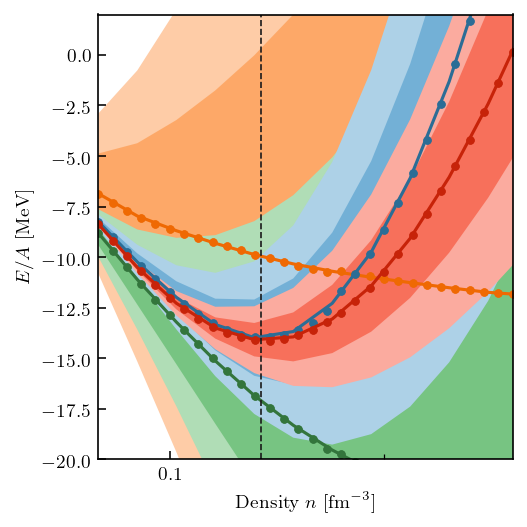

In [26]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True), 
        # just proof of finite difference failing
        wrt_kf=True,
    )
    
ax.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9])#, 2.2, 2.5, 2.8, 3.1])
ax.set_ylim(-20, 2.0)
ax.set_xlim(0.05,.34)
ax.set_ylabel(r'$E/A$ [MeV]');

# calculate Q wrt kf instead of n 
hbarc = 197.327 
kf_cutoff = 600/hbarc

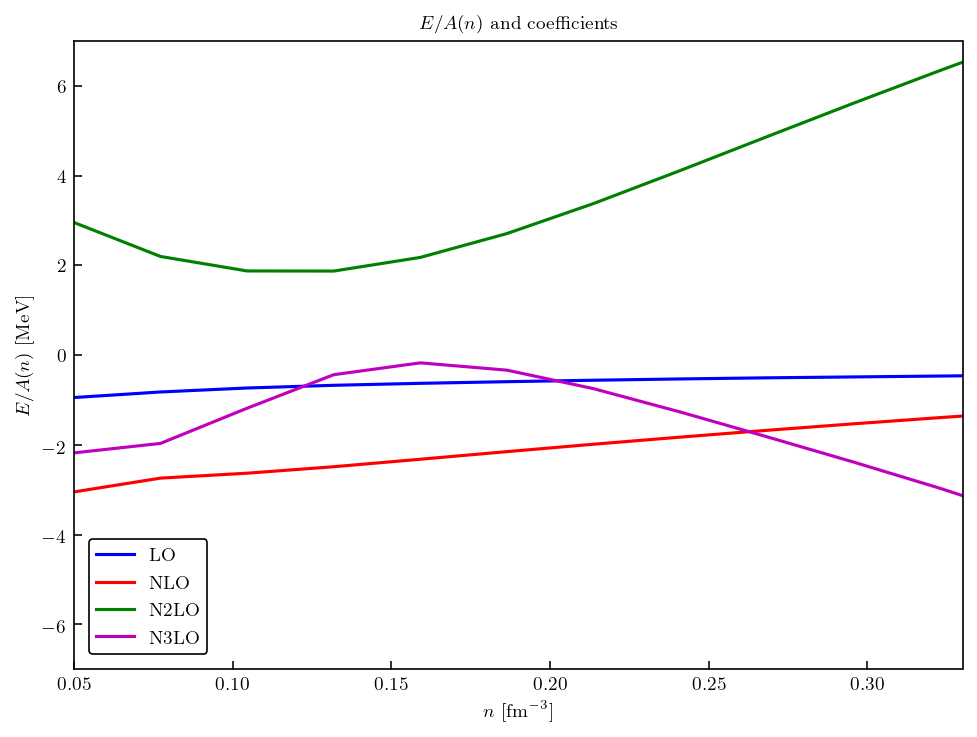

In [28]:
epp = [obs_nuclear.get_pred(order=n, deriv=0) for n in chiral.orders]

hbarc = 197.327 # MeV fm

# we want to see if the coefficients at each order are naturally sized
# check LO from here (easy)
kf_s = hbarc * (3.0 * np.pi**2.0 * chiral.density_all/2.0)**(1.0/3.0)  #[MeV]
kf_0 = hbarc * (3.0 * np.pi**2.0 * 0.164/2.0)**(1.0/3.0)    # [MeV]
yref_n = 16.0 * (kf_s/kf_0)**(2.0)    # [MeV]

# try dividing by yref here (simple test for mean results)
LO_coeff = epp[0]/yref_n

# Q
exp_Q = (kf_s/chiral.breakdown)   # [dimensionless]

# second one (now mindful of Q)
NLO_coeff = ((epp[1]/yref_n) - LO_coeff)/(exp_Q)**2.0

# third one (N2LO)
N2LO_coeff = ((epp[2]/yref_n) - NLO_coeff*(exp_Q)**2.0 - LO_coeff)/(exp_Q)**3.0

# fourth one (N3LO)
N3LO_coeff = ((epp[3]/yref_n) - N2LO_coeff*(exp_Q)**3.0 - NLO_coeff*(exp_Q)**2.0 - LO_coeff)/(exp_Q)**4.0

plt.xlim(0.05, 0.33)
plt.ylim(-7,7)
plt.xlabel(r'$n$ [fm$^{-3}$]')
plt.ylabel(r'$E/A(n)$ [MeV]')
plt.title(r'$E/A(n)$ and coefficients')
plt.plot(chiral.density_all, LO_coeff, 'b', label='LO')
plt.plot(chiral.density_all, NLO_coeff, 'r', label='NLO')
plt.plot(chiral.density_all, N2LO_coeff, 'g', label='N2LO')
plt.plot(chiral.density_all, N3LO_coeff, 'm', label='N3LO')
plt.legend(loc='lower left')
plt.show()

Now that we have a handle on the EFT itself, we will move to the truncation errors. For each order, they should be on the order of the next power. 

Using only truncation error:


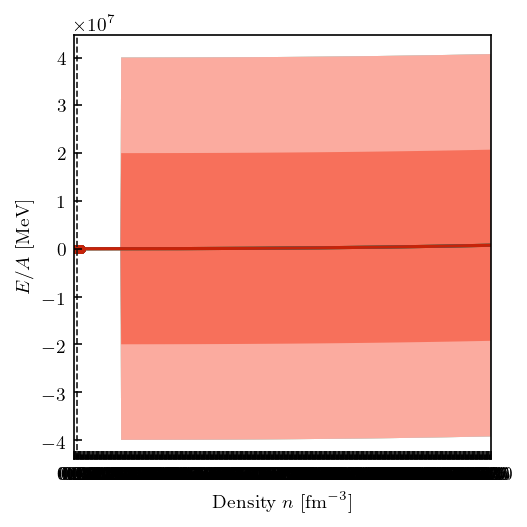

Using only interpolation error:


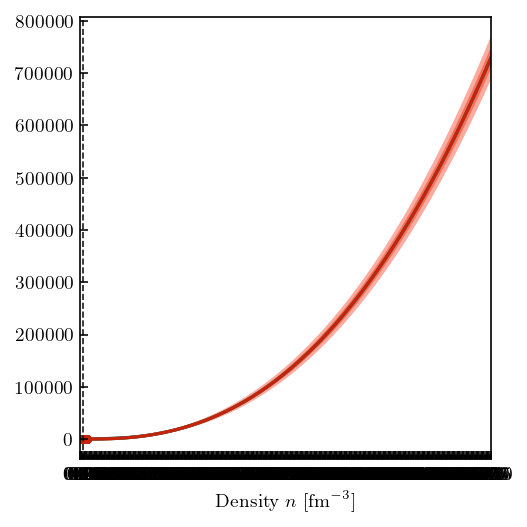

Using both truncation and interpolation error:


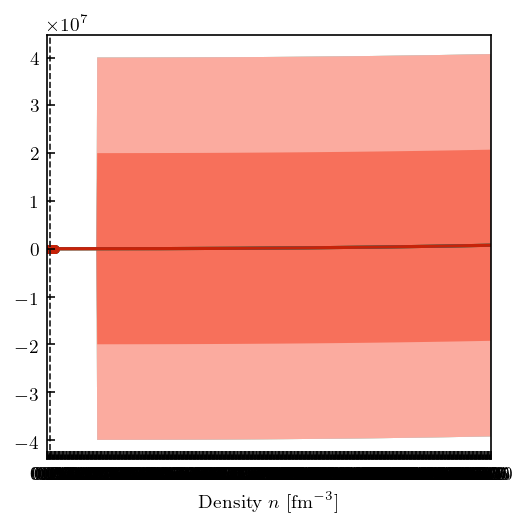

In [29]:
# look at the truncation error bands now at each order and test their scaling
trunc_std = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
for i, n in enumerate(chiral.orders):
    trunc_std[i] = obs_nuclear.get_trunc_std(order=n, deriv=0)

# now take this and plot it 
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))

print('Using only truncation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_trunc_std(order=n, deriv=0),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        #zorder=i/10,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
ax.set_ylabel(r'$E/A$ [MeV]');
plt.show()

# now only plot the interpolation GP errors
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
# ax.set_ylim(-50,50)
# ax.set_ylim(-1000, 1000)
print('Using only interpolation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=False),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        #zorder=i/10,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
plt.show()

# now plot both
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
#ax.set_ylim(-50,50)
#ax.set_ylim(-1000, 1000)
print('Using both truncation and interpolation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        #zorder=i/10,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
plt.show()

Text(0, 0.5, 'E/A [MeV]')

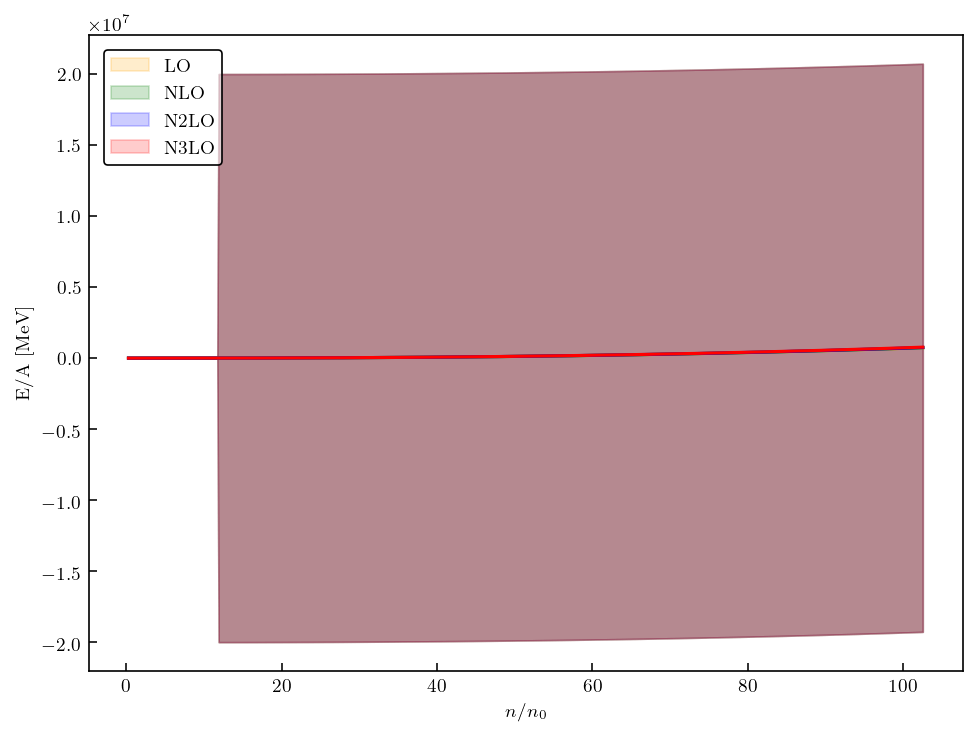

In [30]:
# now we want to look at the powers with which these functions' errors increase, so we look
# at the truncation error band and how it grows with density
# add the truncation error band to the mean
high_edge = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
low_edge = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
trunc_values = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
# analyse dict for std_trunc_vecs (1 does not exist)
for i,n in enumerate(chiral.orders):
    trunc_values[i] = obs_nuclear.get_trunc_std(order=n, deriv=0)
    
# now we add this to the current means
for i,n in enumerate(chiral.orders):
    high_edge[i] = 1.0 * trunc_values[i] + epp[i]
    low_edge[i] = -1.0 * trunc_values[i] + epp[i]

# plot this
# plt.plot(density_all, high_edge[0], color='orange',  linewidth=0, marker='.', label='LO')
# plt.plot(density_all, low_edge[0], color='orange', linewidth=0, marker='.')
plt.fill_between(density_all/0.16, low_edge[0], high_edge[0], color='orange', alpha=0.2, edgecolor=None, label='LO')
#plt.plot(density_all, epp[0], 'b.')
# plt.plot(density_all, high_edge[1], 'g.', label='NLO')
# plt.plot(density_all, low_edge[1], 'g.')
plt.fill_between(density_all/0.16, low_edge[1], high_edge[1], color='g', alpha=0.2, edgecolor=None, label='NLO')
#plt.plot(density_all, epp[1], 'r.')
# plt.plot(density_all, high_edge[2], 'b.', label='N2LO')
# plt.plot(density_all, low_edge[2], 'b.')
plt.fill_between(density_all/0.16, low_edge[2], high_edge[2], color='b', alpha=0.2, edgecolor=None, label='N2LO')
#plt.plot(density_all, epp[2], 'g.')
# plt.plot(density_all, high_edge[3], 'r.', label='N3LO')
# plt.plot(density_all, low_edge[3], 'r.')
plt.fill_between(density_all/0.16, low_edge[3], high_edge[3], color='r', alpha=0.2, edgecolor=None, label='N3LO')
#plt.plot(density_all, epp[3], 'm.')
plt.legend(loc='upper left')

# just the density dependence now
dens_LO = (chiral.density_all/0.16)**(4.0/3.0)
dens_NLO = (chiral.density_all/0.16)**(5.0/3.0)
dens_N2LO = (chiral.density_all/0.16)**(6.0/3.0)
dens_N3LO = (chiral.density_all/0.16)**(7.0/3.0)

# matching density dependence 
func_form_LO = 10.6 * (chiral.density_all/0.16)**(4.0/3.0) + epp[0] 
func_form_NLO = 4.6 * (chiral.density_all/0.16)**(5.0/3.0) + epp[1]
func_form_N2LO = 2.0 * (chiral.density_all/0.16)**(6.0/3.0) + epp[2]
func_form_N3LO = 0.9 * (chiral.density_all/0.16)**(7.0/3.0) + epp[3]

# add the bands in quadrature to see what happens (N3LO case only)
interp_only = obs_nuclear.get_std(order=4, deriv=0, include_trunc=False)
trunc_interp = obs_nuclear.get_std(order=4, deriv=0, include_trunc=True)
quad_error = np.sqrt(np.square(interp_only) + np.square(0.9 * dens_N3LO))

# now map the density**5/3 and see if it overlays well
# plt.xlim(0.05/0.16, 0.33/0.16)
# plt.ylim(-20,20)
plt.plot(density_all/0.16, func_form_LO, 'orange')
plt.plot(density_all/0.16, func_form_NLO, 'g')
plt.plot(density_all/0.16, func_form_N2LO, 'b')
plt.plot(density_all/0.16, func_form_N3LO, 'r')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel('E/A [MeV]')

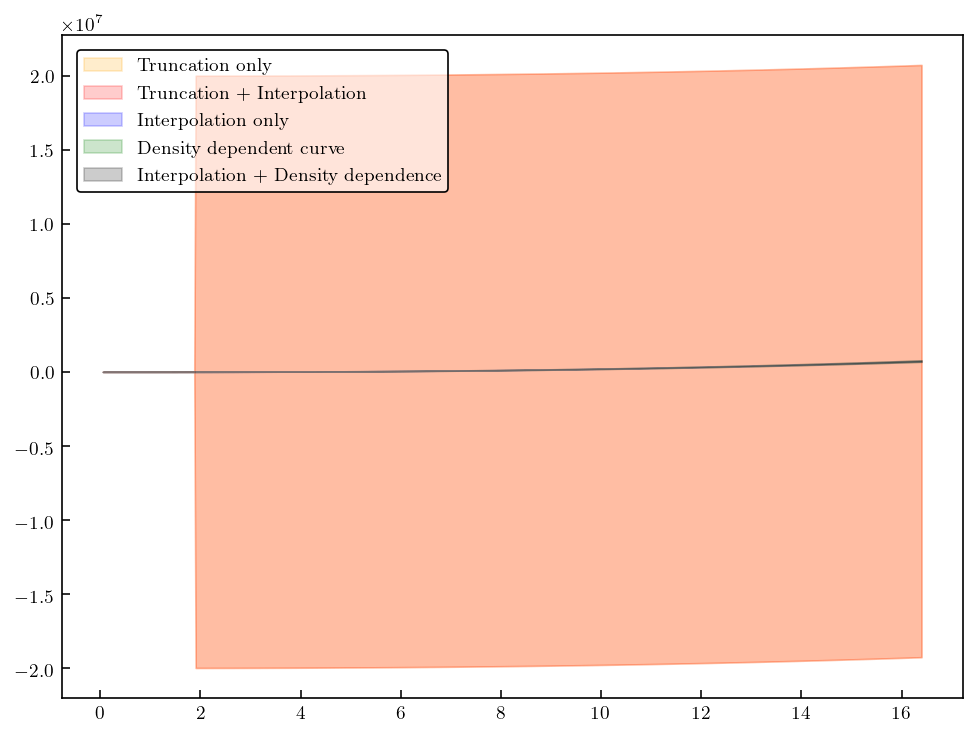

In [31]:
# overlay truncation + interp and only interp to see differences farther out
plt.fill_between(density_all, epp[3] - chiral.obs_nuclear.get_trunc_std(order=4, deriv=0), epp[3] + chiral.obs_nuclear.get_trunc_std(order=4, deriv=0), \
                 color='orange', alpha=0.2, label='Truncation only')
plt.fill_between(density_all, epp[3] - chiral.obs_nuclear.get_std(order=4, deriv=0, include_trunc=True), \
                 epp[3] + chiral.obs_nuclear.get_std(order=4, deriv=0, include_trunc=True), color='r', alpha=0.2, \
                label='Truncation + Interpolation')
plt.fill_between(density_all, epp[3] - chiral.obs_nuclear.get_std(order=4, deriv=0, include_trunc=False), \
                 epp[3] + chiral.obs_nuclear.get_std(order=4, deriv=0, include_trunc=False), color='b', alpha=0.2, \
                label='Interpolation only')
plt.fill_between(density_all, epp[3] - 0.9 * dens_N3LO, epp[3] + 0.9 * dens_N3LO, color='g', alpha=0.2, \
                 label='Density dependent curve')
plt.fill_between(density_all, epp[3] - quad_error, epp[3] + quad_error, color='k', alpha=0.2, \
                 label='Interpolation + Density dependence')
plt.legend(loc='upper left')

# plot the Q = 0.5 line
dens_Q_12 =(0.5 * chiral.breakdown)**(3.0) * 2.0/(3.0*np.pi**2)/hbarc**3.0

__Interesting to note above that the density dependence does take over farther out and beats our current cutoff. Would it be more realistic to take a piecewise polytrope kind of approach and use the density dependence when it takes over?__

Create a Gaussian random variable based on the posterior for the saturation density found for our Hamiltonians.
Sample saturation densities from it.

In [32]:
sat_density_ham_dist = stats.norm(0.17, 0.01)
sat_density_ham_dist_n2lo = stats.norm(0.17, 0.02)
num_sats = 101

np.random.seed(1)
d_sats = sat_density_ham_dist.rvs(num_sats)
d_sats_n2lo = sat_density_ham_dist_n2lo.rvs(num_sats)
D_sats = d_sats[:, None]

kf_n_sats = fermi_momentum(d_sats, 2)
Kf_n_sats = kf_n_sats[:, None]

kf_s_sats = fermi_momentum(d_sats, 4)
Kf_s_sats = kf_s_sats[:, None]

These will be used later on to get posteriors with full uncertainties for the incompressibility $K$, and $S_v$--$L$ correlations

## Make Order-by-Order Predictions with Uncertainties <a id="order_by_order"></a>

Our GPs are defined to be stationary over momentum, but most formula for EOS properties use derivatives with respect to density.
So our derivatives must make use of the chain rule.
This is all handled inside functions like `compute_pressure`, `compute_pressure_cov`, etc., which can all be told whether the inputs use `kf` or `n` as the space for derivatives.

In [33]:
from nuclear_matter import kf_derivative_wrt_density

The pressure is given by
$$ 
P = n^2 \frac{d}{dn} \frac{E}{A} = n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = n \frac{k_f}{3} \frac{d}{dk_f}  \frac{E}{A}
$$
where $k_f = \sqrt[3]{3\pi^2\, n/2}$ ($k_f = \sqrt[3]{3\pi^2\, n}$) for symmetric (neutron) matter.

It is useful to note that
\begin{align}
    \frac{dk}{dn} & = \frac{k}{3n} \\
    \frac{d^2k}{dn^2} & = -\frac{2k}{9n^2}
\end{align}

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


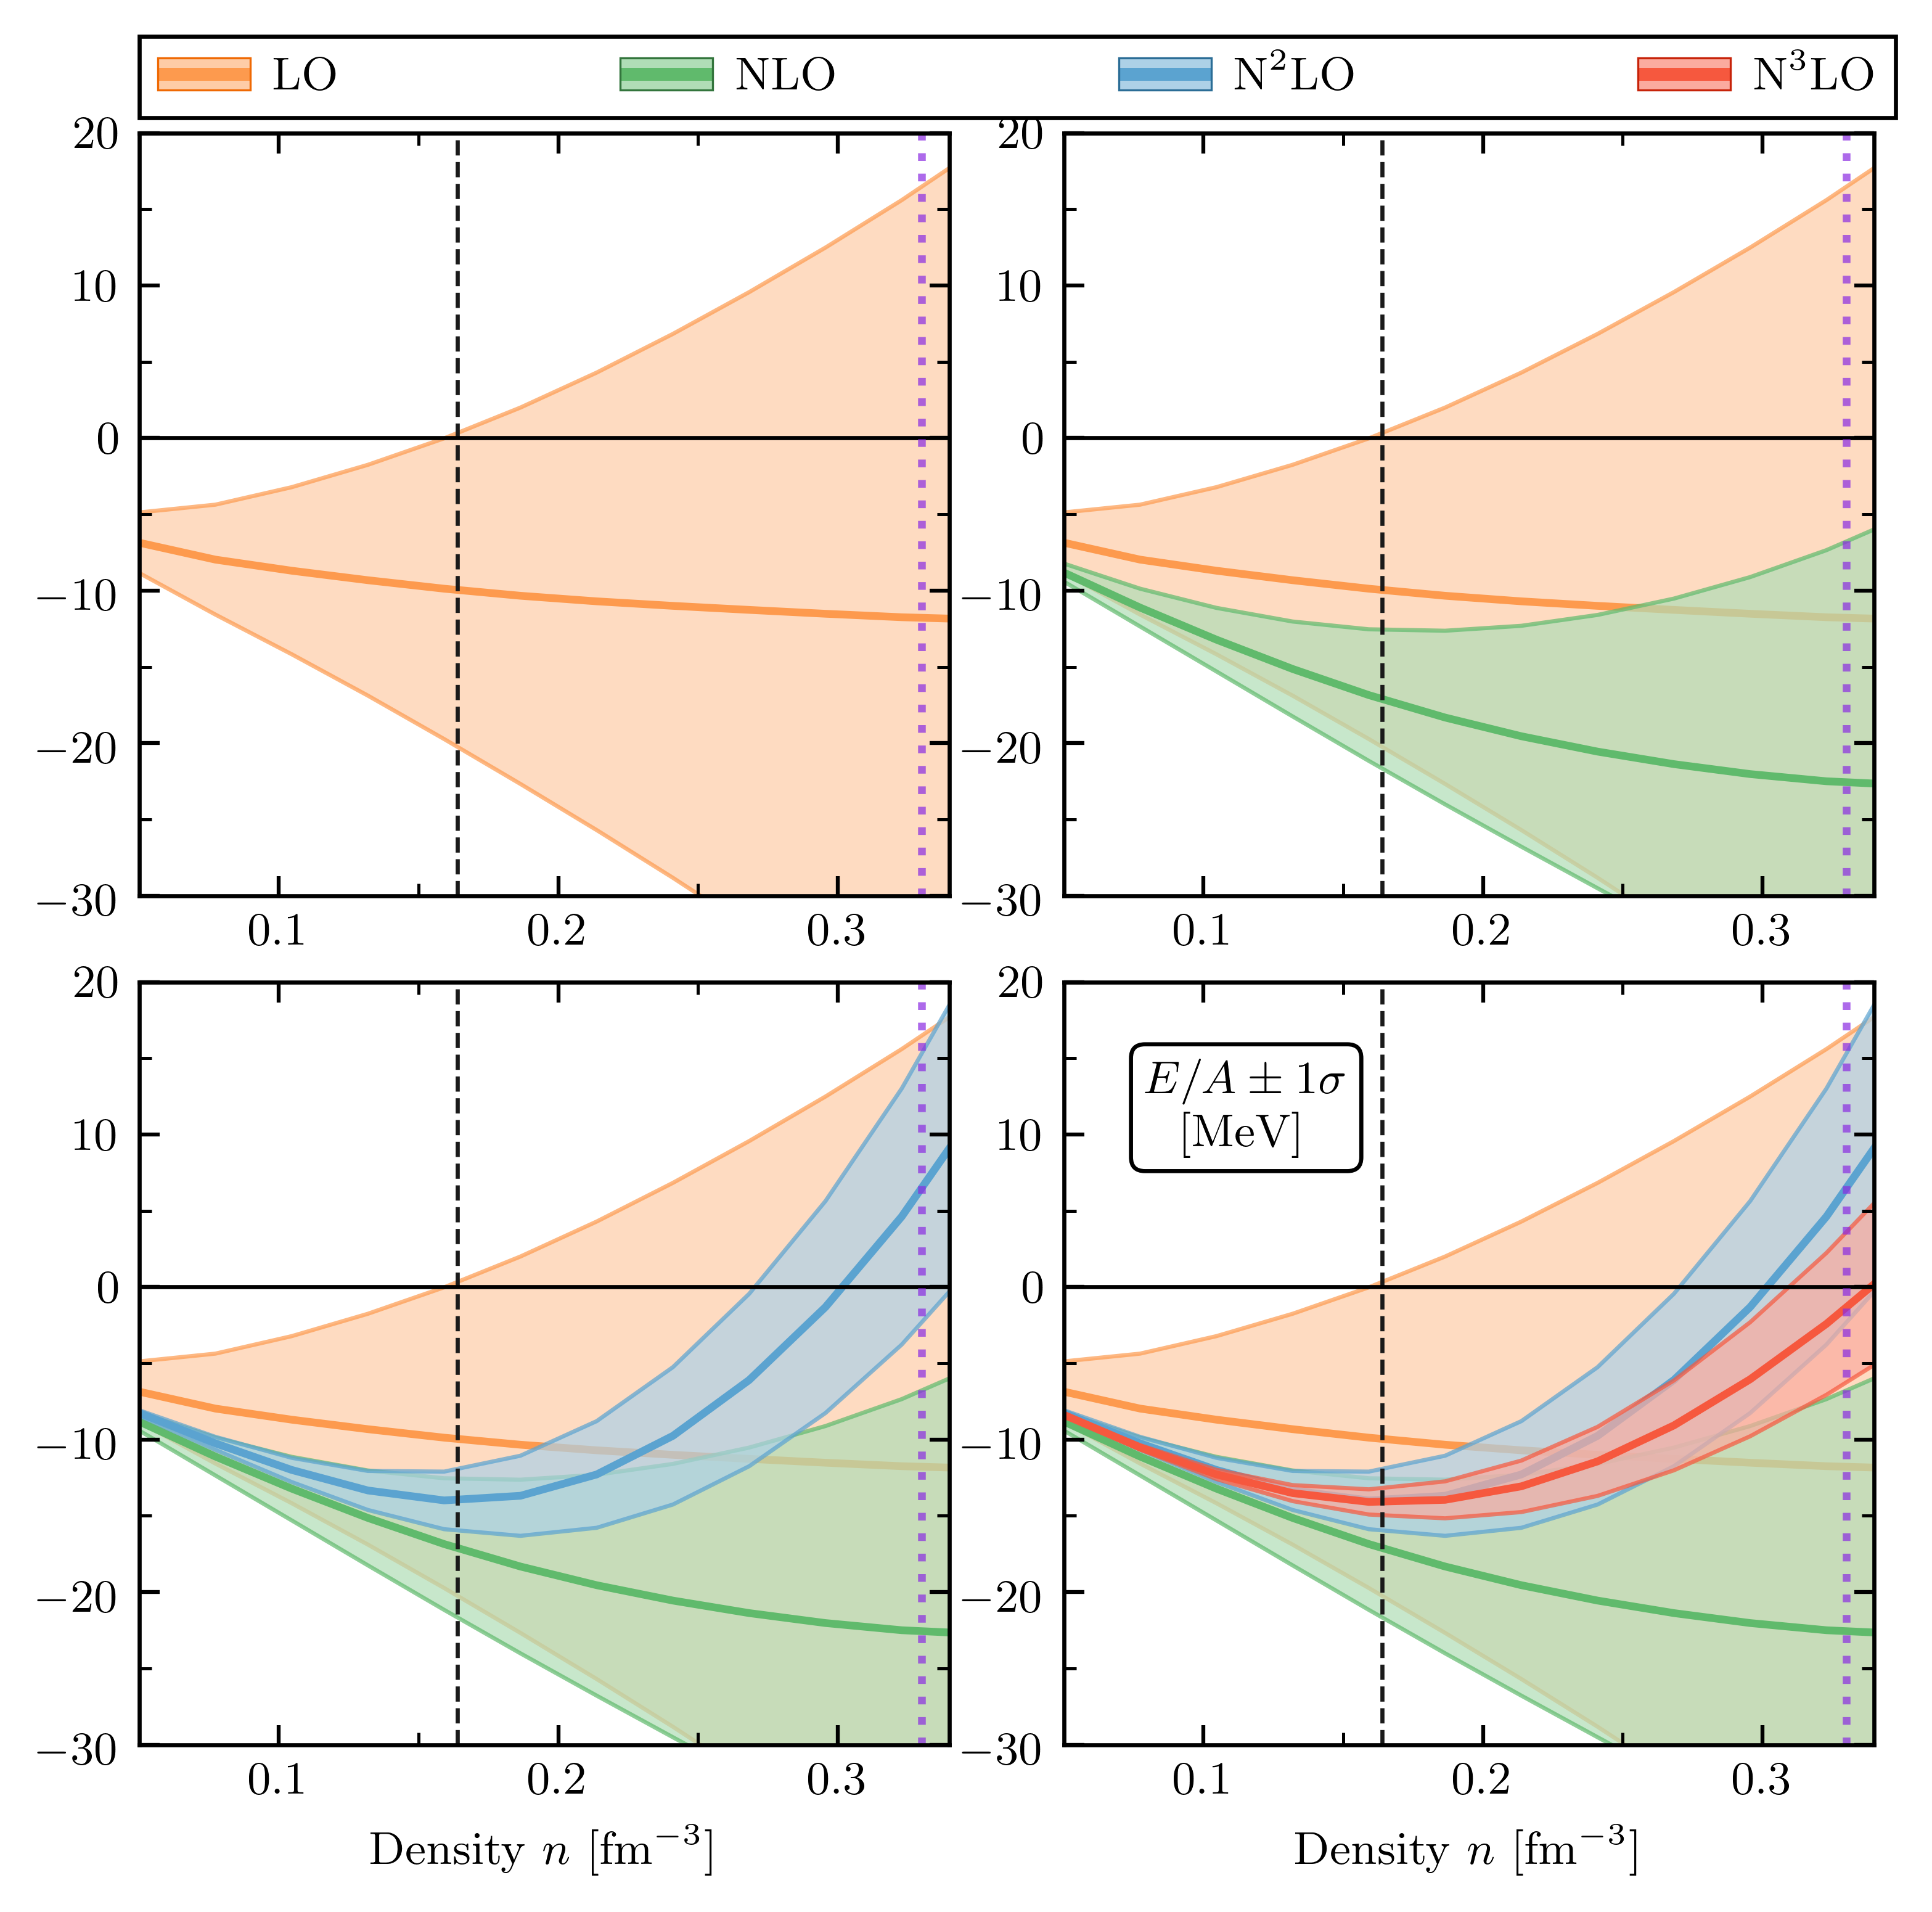

-14.089519383199388


In [34]:
# energies_s = np.array([obs_nuclear.get_pred(order=n, deriv=0) for n in orders]).T
# energy_s_stds = np.array([obs_nuclear.get_std(order=n, deriv=0, include_trunc=True) for n in orders]).T

# # adding the rest mass in (average p,n)
# rest_mass = 938.91875434       # MeV

# # multiply all quantities in E/A arrays at all orders
# energies_s_mn = energies_s + rest_mass

energies_s_mn, energy_s_stds = chiral.energy_per_particle(add_rest_mass=False)

fig, axes = plot_obs_panels(
    density_all, y=energies_s_mn, dy=energy_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

# axes[0, 0].set_ylim(915, 950-1e-5)
# axes[1, 0].set_ylim(915, 950-1e-5)
# axes[0, 0].set_ylim(-1000, 3000-1e-5)
# axes[1, 0].set_ylim(-1000, 3000-1e-5)
axes[0, 0].set_ylim(-30, 20)
axes[1, 0].set_ylim(-30, 20)
axes[1, 1].set_ylim(-30, 20)
axes[0, 1].set_ylim(-30, 20)
for ax in axes.reshape(-1):
    ax.set_xlim(0.05, 0.34)
    #ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

label = r"""$E/A \pm 1\sigma$
[MeV]""" # axes[0,0]
ax.text( 
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()
print(min(energies_s_mn[:,3]))

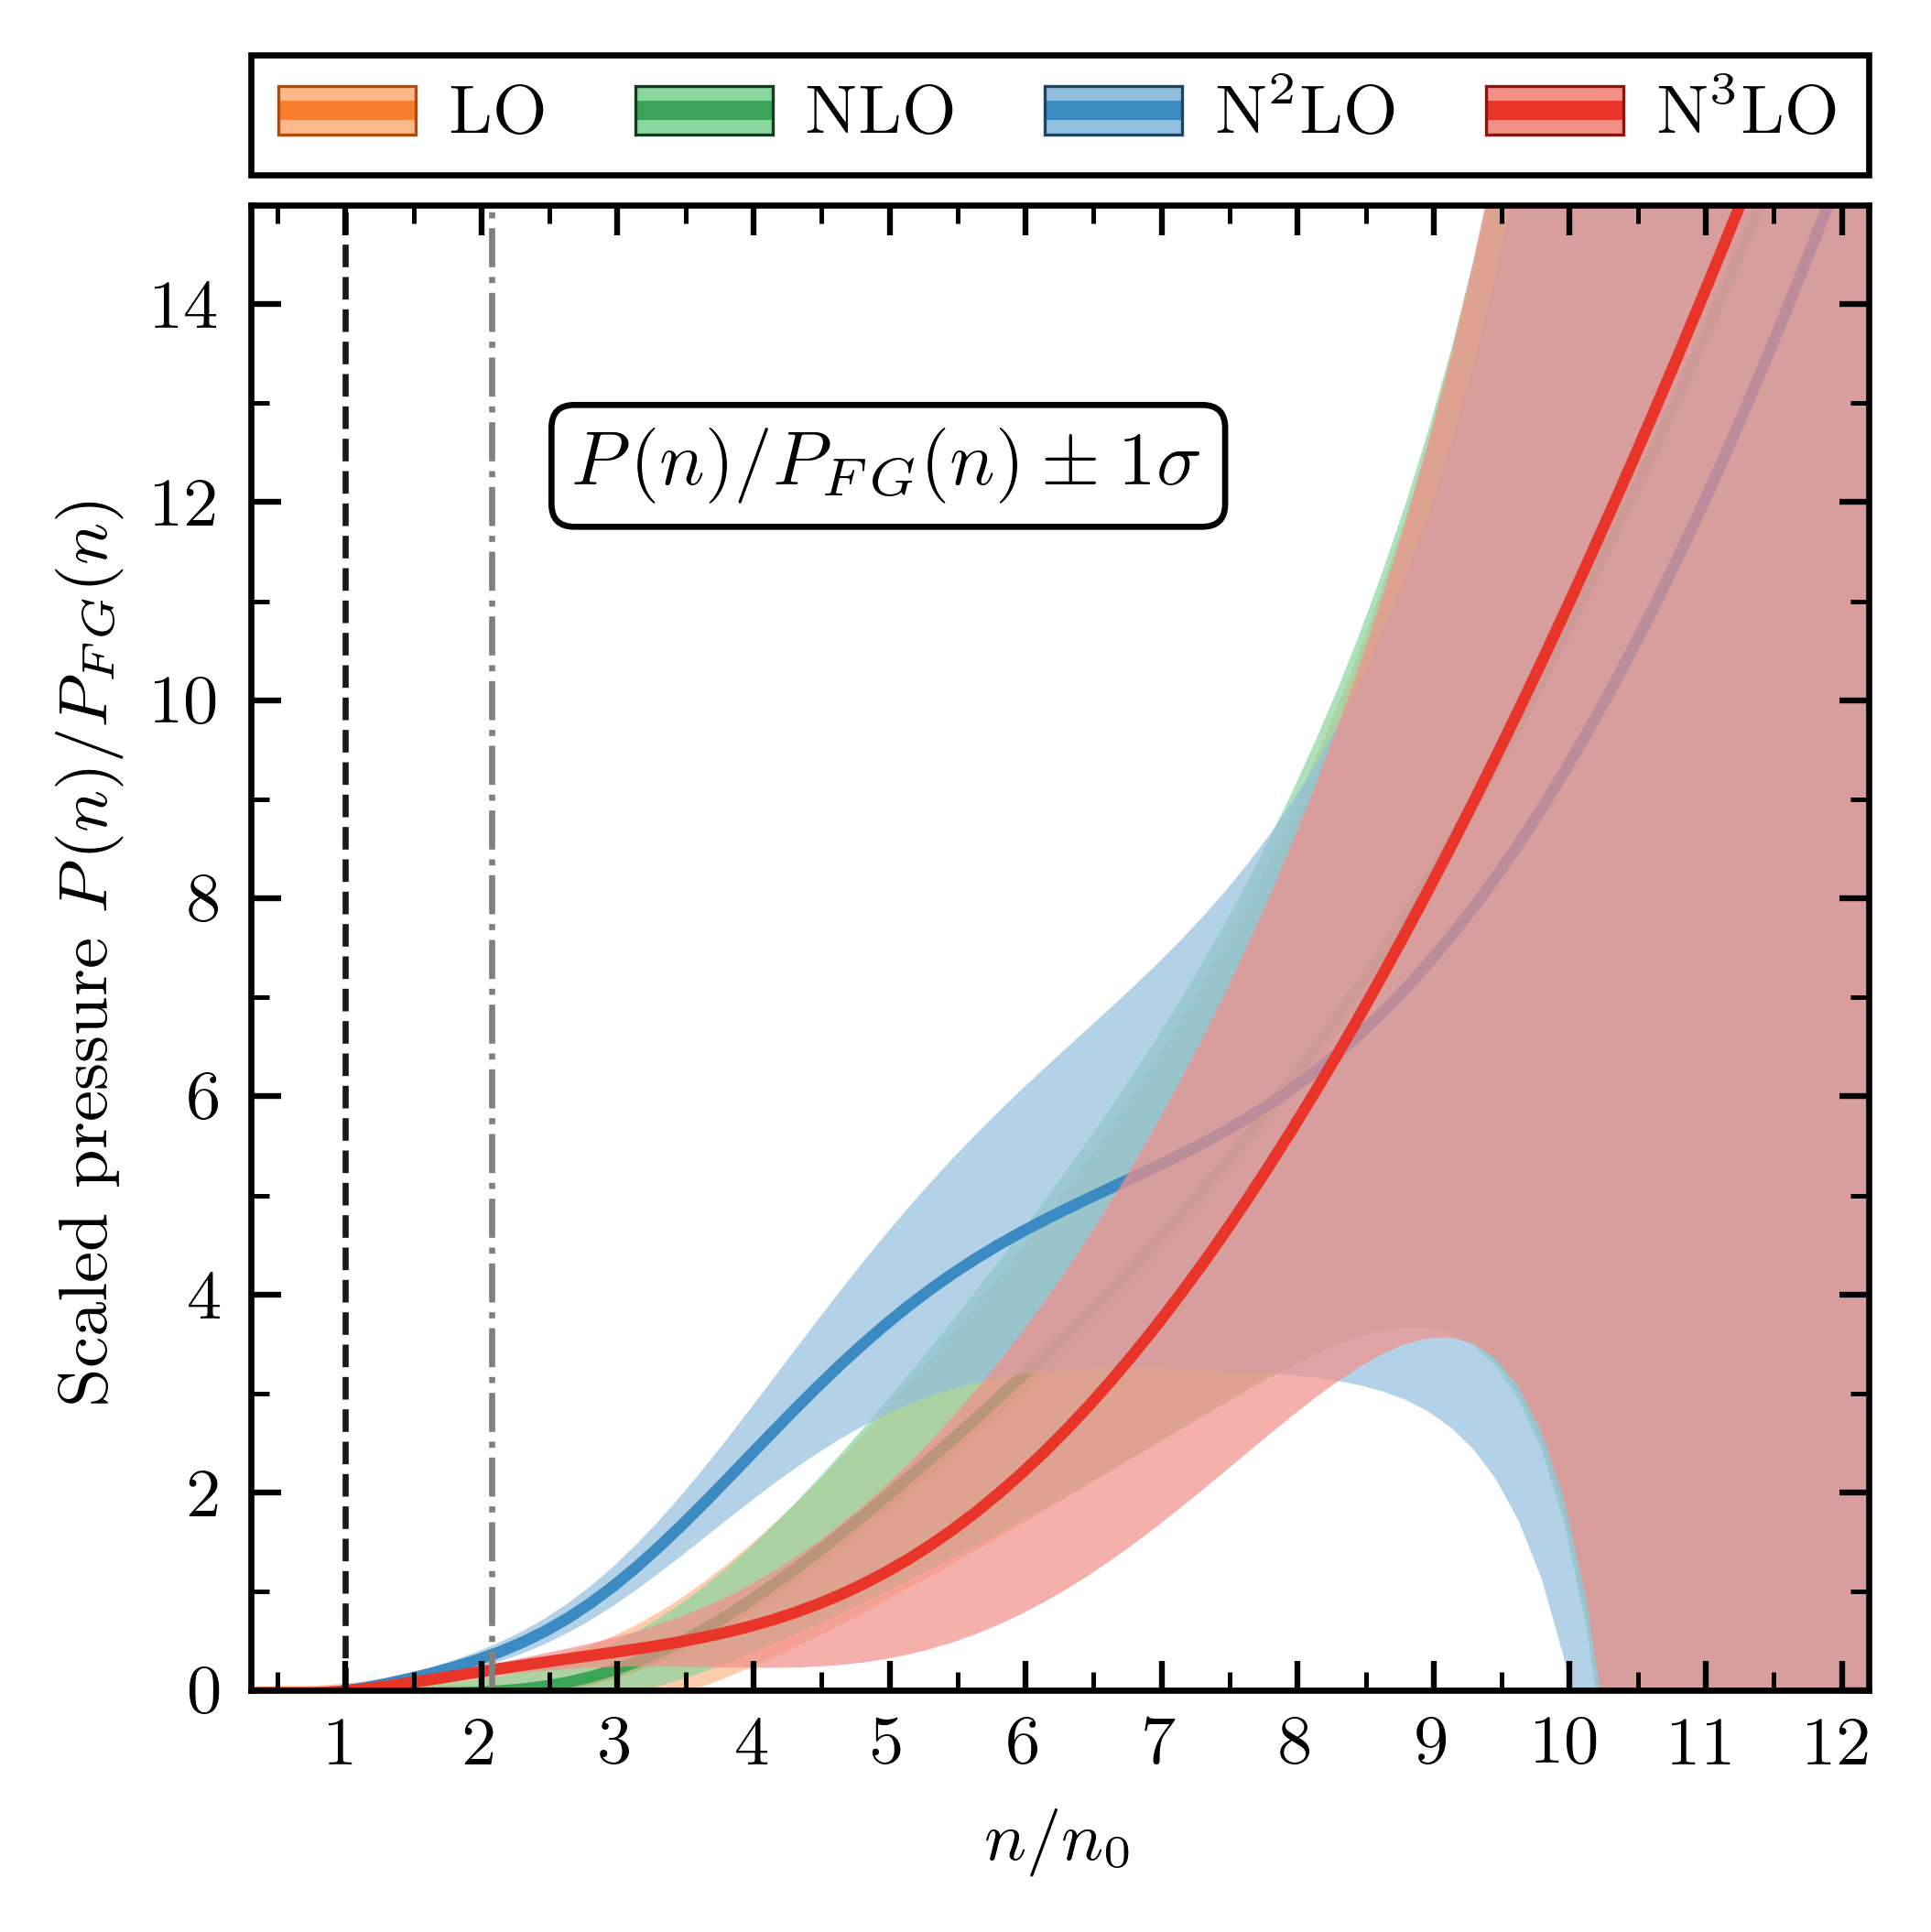

In [37]:
# calculate the values of Q at each point in density space
def q_calc(density):
    # momentum first from density_all
    hbarc = 197.327 # MeV fm 
    kf = ((3.0*np.pi**2.0)*density/2.0)**(1.0/3.0)  # fm^-1
    lamb = 600./hbarc   # MeV/MeV fm = fm^-1
    Q_vals = kf/lamb
    
    return Q_vals

n0 = 0.164

# calculate it only between the current 
# limits of density on the plot
# current_lims = [0.05/n0, 2.0/n0]
# q_vals = q_calc(density_all)

# (B) figure 13 and SM 8
# pressures_s = []
# pressure_s_stds = []
# pressure_s_fits = []
# for i, n in enumerate(orders):
#     pressure_s = compute_pressure(
#         obs_nuclear.density_interp,
#         obs_nuclear.kf_interp,
#         dE=obs_nuclear.get_pred(order=n, deriv=1)
#     )
#     pressure_s_cov = compute_pressure_cov(
#         obs_nuclear.density_interp,
#         obs_nuclear.kf_interp,
#         dE_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1)
#     )
#     pressure_s_std = np.sqrt(np.diag(pressure_s_cov))

#     pressure_alt_diff_s = compute_pressure(
#         obs_nuclear.density,
#         obs_nuclear.kf,
#         dE=obs_nuclear.poly_interp(order=n, deriv=1, wrt_kf=False),
#         wrt_kf=False
#     )
#     pressures_s.append(pressure_s)
#     pressure_s_stds.append(pressure_s_std)
#     pressure_s_fits.append(pressure_alt_diff_s)

# pressures_s = np.array(pressures_s).T
# pressure_s_stds = np.array(pressure_s_stds).T
# pressure_s_fits = np.array(pressure_s_fits).T

# call the chiral pressure function 
pressures_s, pressure_s_stds, pressure_s_cov = chiral.pressure(orders='all')

# fill std with zeros for initial plot
pressure_s_stds_0 = np.zeros([len(density_all), len(chiral.orders)])

# fig, axes = plot_obs_panels(
#     density_all, y=pressures_s, dy=pressure_s_stds, orders=chiral.orders,
# #     density_data=density[::3], y_data=pressure_s_fits[::3],
#     colors=colors, fillstyle='none', markeredgewidth=0.5,
# )

# axes[0, 0].set_ylim(-10, 25-1e-5)
# axes[1, 0].set_ylim(-10, 25-1e-5)
# axes[1, 1].set_ylim(-10, 25-1e-5)
# axes[0, 1].set_ylim(-10, 25-1e-5)

# for the old range of truncation error
# fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
# from nuclear_matter import lighten_color
# color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
# cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
# colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
# light_colors = [lighten_color(color, 0.55) for color in colors]
# dark_colors = [lighten_color(color, 1.5) for color in colors]
# for i, n in enumerate(chiral.orders):
#     plot_obs_vs_density(
#         density_all,
#         pressures_s[:,i],
#         pressure_s_stds[:,i],
#         ax=ax,
#         color_68=light_colors[i],
#    #     color_95=light_colors[i],
#         c=colors[i],
#         add_nsat=i==len(chiral.orders)-1,
#         zorder=i/10,
#     )
# ax.xaxis.set_major_locator(MultipleLocator(0.05))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.tick_params(right=True, top=True, which='both') # stop for loop after line
# ax.axhline(0, 0, 1, c='k', lw=0.8);
# ax.set_ylabel(r'$\textrm{Pressure}~P(n)$ [MeV/fm$^{3}$]');
# ax.set_ylim(-10, 25-1e-5);
# label = r"""$P \pm 1\sigma$
# [MeV\,fm$^{-3}$]"""
# ax.text(
#     0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
#     multialignment='center', zorder=10, fontsize=10,
#     bbox=dict(facecolor='w', boxstyle='round')
# )
# add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
# fig.savefig('pressure_n_2n0.pdf')
# plt.show()

pressure_free = np.zeros([len(density_all), 4])
hbarc = 197.327 # MeV fm

for i in range(4):
    pressure_free[:,i] = ((1.0/(2.0*np.square(np.pi)))*(chiral.kf_s_all**4.0))*(hbarc)

# for the newer, more expanded code
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all/n0,
        pressures_s[:,i]/pressure_free[:,i],
        pressure_s_stds[:,i]/pressure_free[:,i],
        ax=ax,
        color_68=light_colors[i],
   #     color_95=light_colors[i],
        c=colors[i],
        add_nsat=i==len(chiral.orders)-1,
        nsat_n0 = True,
        zorder=i/10,
    )
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both') # stop for loop after line
ax.axhline(0, 0, 1, c='k', lw=0.8);
ax.axvline(0.34/n0, c='grey', lw=0.8, linestyle='dashdot');
ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]);
ax.set_xlim(0.05/n0, 2.0/n0)

# add a secondary x axis with Q on it
# ax2 = ax.twiny()
# ax2.set_xlabel('Q')
# ax2.xaxis.set_major_formatter(plt.FuncFormatter(q_calc))

#ax.set_xscale('log')
ax.set_ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$');
ax.set_xlabel(r'$n/n_{0}$')
#ax.set_ylim(-10, 25-1e-5);  # old one
ax.set_ylim(0.0, 15.0)
label = r"""$P(n)/P_{FG}(n) \pm 1\sigma$"""
ax.text(
    0.2, 0.85, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
#fig.savefig('pressure_scaled_trunc.PNG')
plt.show()

In [38]:
# # saving the mean, std_dev, and cov for E/A
# # mean_chiral_EA = obs_nuclear.get_pred(order=4, deriv=0)
# # std_dev_chiral_EA = obs_nuclear.get_std(order=4, deriv=0, include_trunc=True)
# # cov_matrix_chiral_EA = obs_nuclear.get_cov(order=4, deriv1=0, include_trunc=True)

# # saving the mean, std_dev, and cov for E/A
# # call pressure from chiral.py
pressure_s, pressure_s_stds, pressure_s_cov = chiral.pressure(orders='all')
mean_chiral_pressure = pressure_s
std_dev_chiral_pressure = pressure_s_stds
cov_matrix_chiral_pressure = pressure_s_cov

# write this to a file
# if density_all.size >= 600:
#     np.savez('pressure_chiral_data', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure, std_dev=std_dev_chiral_pressure, \
#              cov=cov_matrix_chiral_pressure)

#     # open the file here and check it
#     npzfile = np.load('pressure_chiral_data.npz')
#     npzfile.files

#     print(npzfile['mean'].shape, npzfile['std_dev'].shape, npzfile['cov'].shape)

#     std_from_cov = np.sqrt(np.diag(npzfile['cov'][:,:,3]))
#     print(std_from_cov - npzfile['std_dev'][:,3])
# else:
#     print('Not saved.')

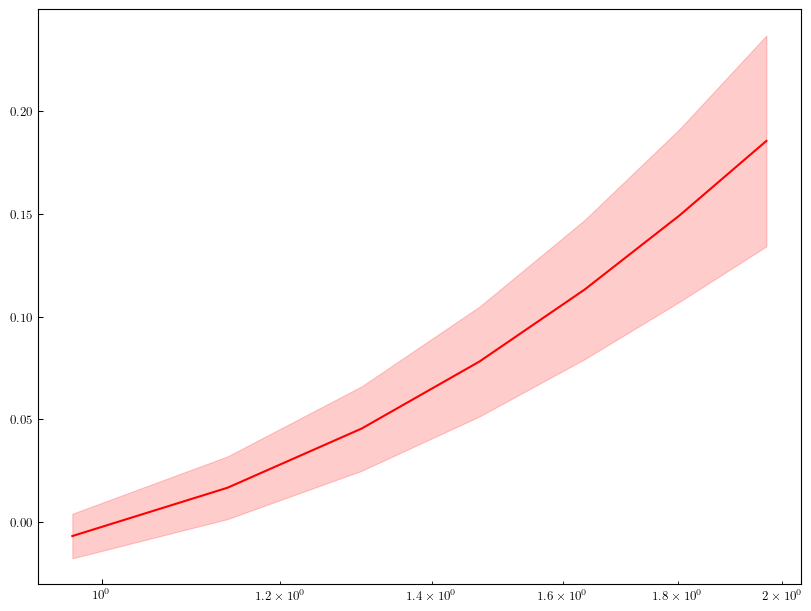

In [39]:
# divide out by the free quark pressure (checking against the plot in chiral EFT in the SNM paper)
pressure_free = np.zeros([len(density_all), 4])
hbarc = 197.327 # MeV fm

for i in range(4):
    pressure_free[:,i] = ((1.0/(2.0*np.square(np.pi)))*(chiral.kf_s_all**4.0))*(hbarc)
        
dens_scale = density_all/n0
min_dens = np.where(dens_scale>=1.)[0][0]
max_dens = np.where(dens_scale>=2.)[0][0]
dens_scale = dens_scale[min_dens-1:max_dens]

fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.plot(dens_scale, pressures_s[min_dens-1:max_dens,3]/pressure_free[min_dens-1:max_dens,3], color='red')
ax.fill_between(dens_scale, \
                (pressures_s[min_dens-1:max_dens,3]-pressure_s_stds[min_dens-1:max_dens,3])/pressure_free[min_dens-1:max_dens,3], \
                (pressures_s[min_dens-1:max_dens,3]+pressure_s_stds[min_dens-1:max_dens,3])/pressure_free[min_dens-1:max_dens,3], \
                color='red', alpha=0.2)
ax.set_xscale('log')
axes[0, 0].set_ylim(-20, 25)
axes[1, 0].set_ylim(-20, 25)
label = r"""$P \pm 1\sigma$
[MeV\,fm$^{-3}$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

In [41]:
# # saving the scaled results also to an npz file (efficiency)
mean_chiral_pressure_scaled = np.zeros([len(density_all,), 4])
std_dev_chiral_pressure_scaled = np.zeros([len(density_all), 4])
cov_matrix_chiral_pressure_scaled = np.zeros([len(density_all), len(density_all), 4])

for i in range(len(chiral.orders)):
    mean_chiral_pressure_scaled[:,i] = pressure_s[:,i]/pressure_free[:,i]
    std_dev_chiral_pressure_scaled[:,i] = pressure_s_stds[:,i]/pressure_free[:,i]
                            
for i in range(len(chiral.orders)):
    for j in range(len(density_all)):
        for k in range(len(density_all)):
            cov_matrix_chiral_pressure_scaled[j,k,i] = pressure_s_cov[j,k,i]/(pressure_free[j,i]*pressure_free[k,i])
    
#write this to a file
if density_all.size >= 600:
    np.savez('../data/eos_data/pressure_chiral_data_scaled_PAL', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure_scaled, std_dev=std_dev_chiral_pressure_scaled, \
             cov=cov_matrix_chiral_pressure_scaled)

    # open the file here and check it
    npzfile_scaled = np.load('../data/eos_data/pressure_chiral_data_scaled_PAL.npz')
    npzfile_scaled.files

    #print(npzfile_scaled['mean'].shape, npzfile_scaled['std_dev'].shape, npzfile_scaled['cov'].shape)

    # checking the correctness
    #print(np.sqrt(np.diag(npzfile_scaled['cov'][:,:,3])) - npzfile_scaled['std_dev'][:,3])
    
elif density_all.size <= 300:
    np.savez('../data/eos_data/pressure_chiral_data_scaled_2n0', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure_scaled, std_dev=std_dev_chiral_pressure_scaled, \
             cov=cov_matrix_chiral_pressure_scaled)
else:
    print('Not saved.')

---
## Obtaining $n(\mu)$ 

The first and known thing to do is to determine $\mu(n)$, which is simple enough by taking the information from above and plotting it with respect to n.

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


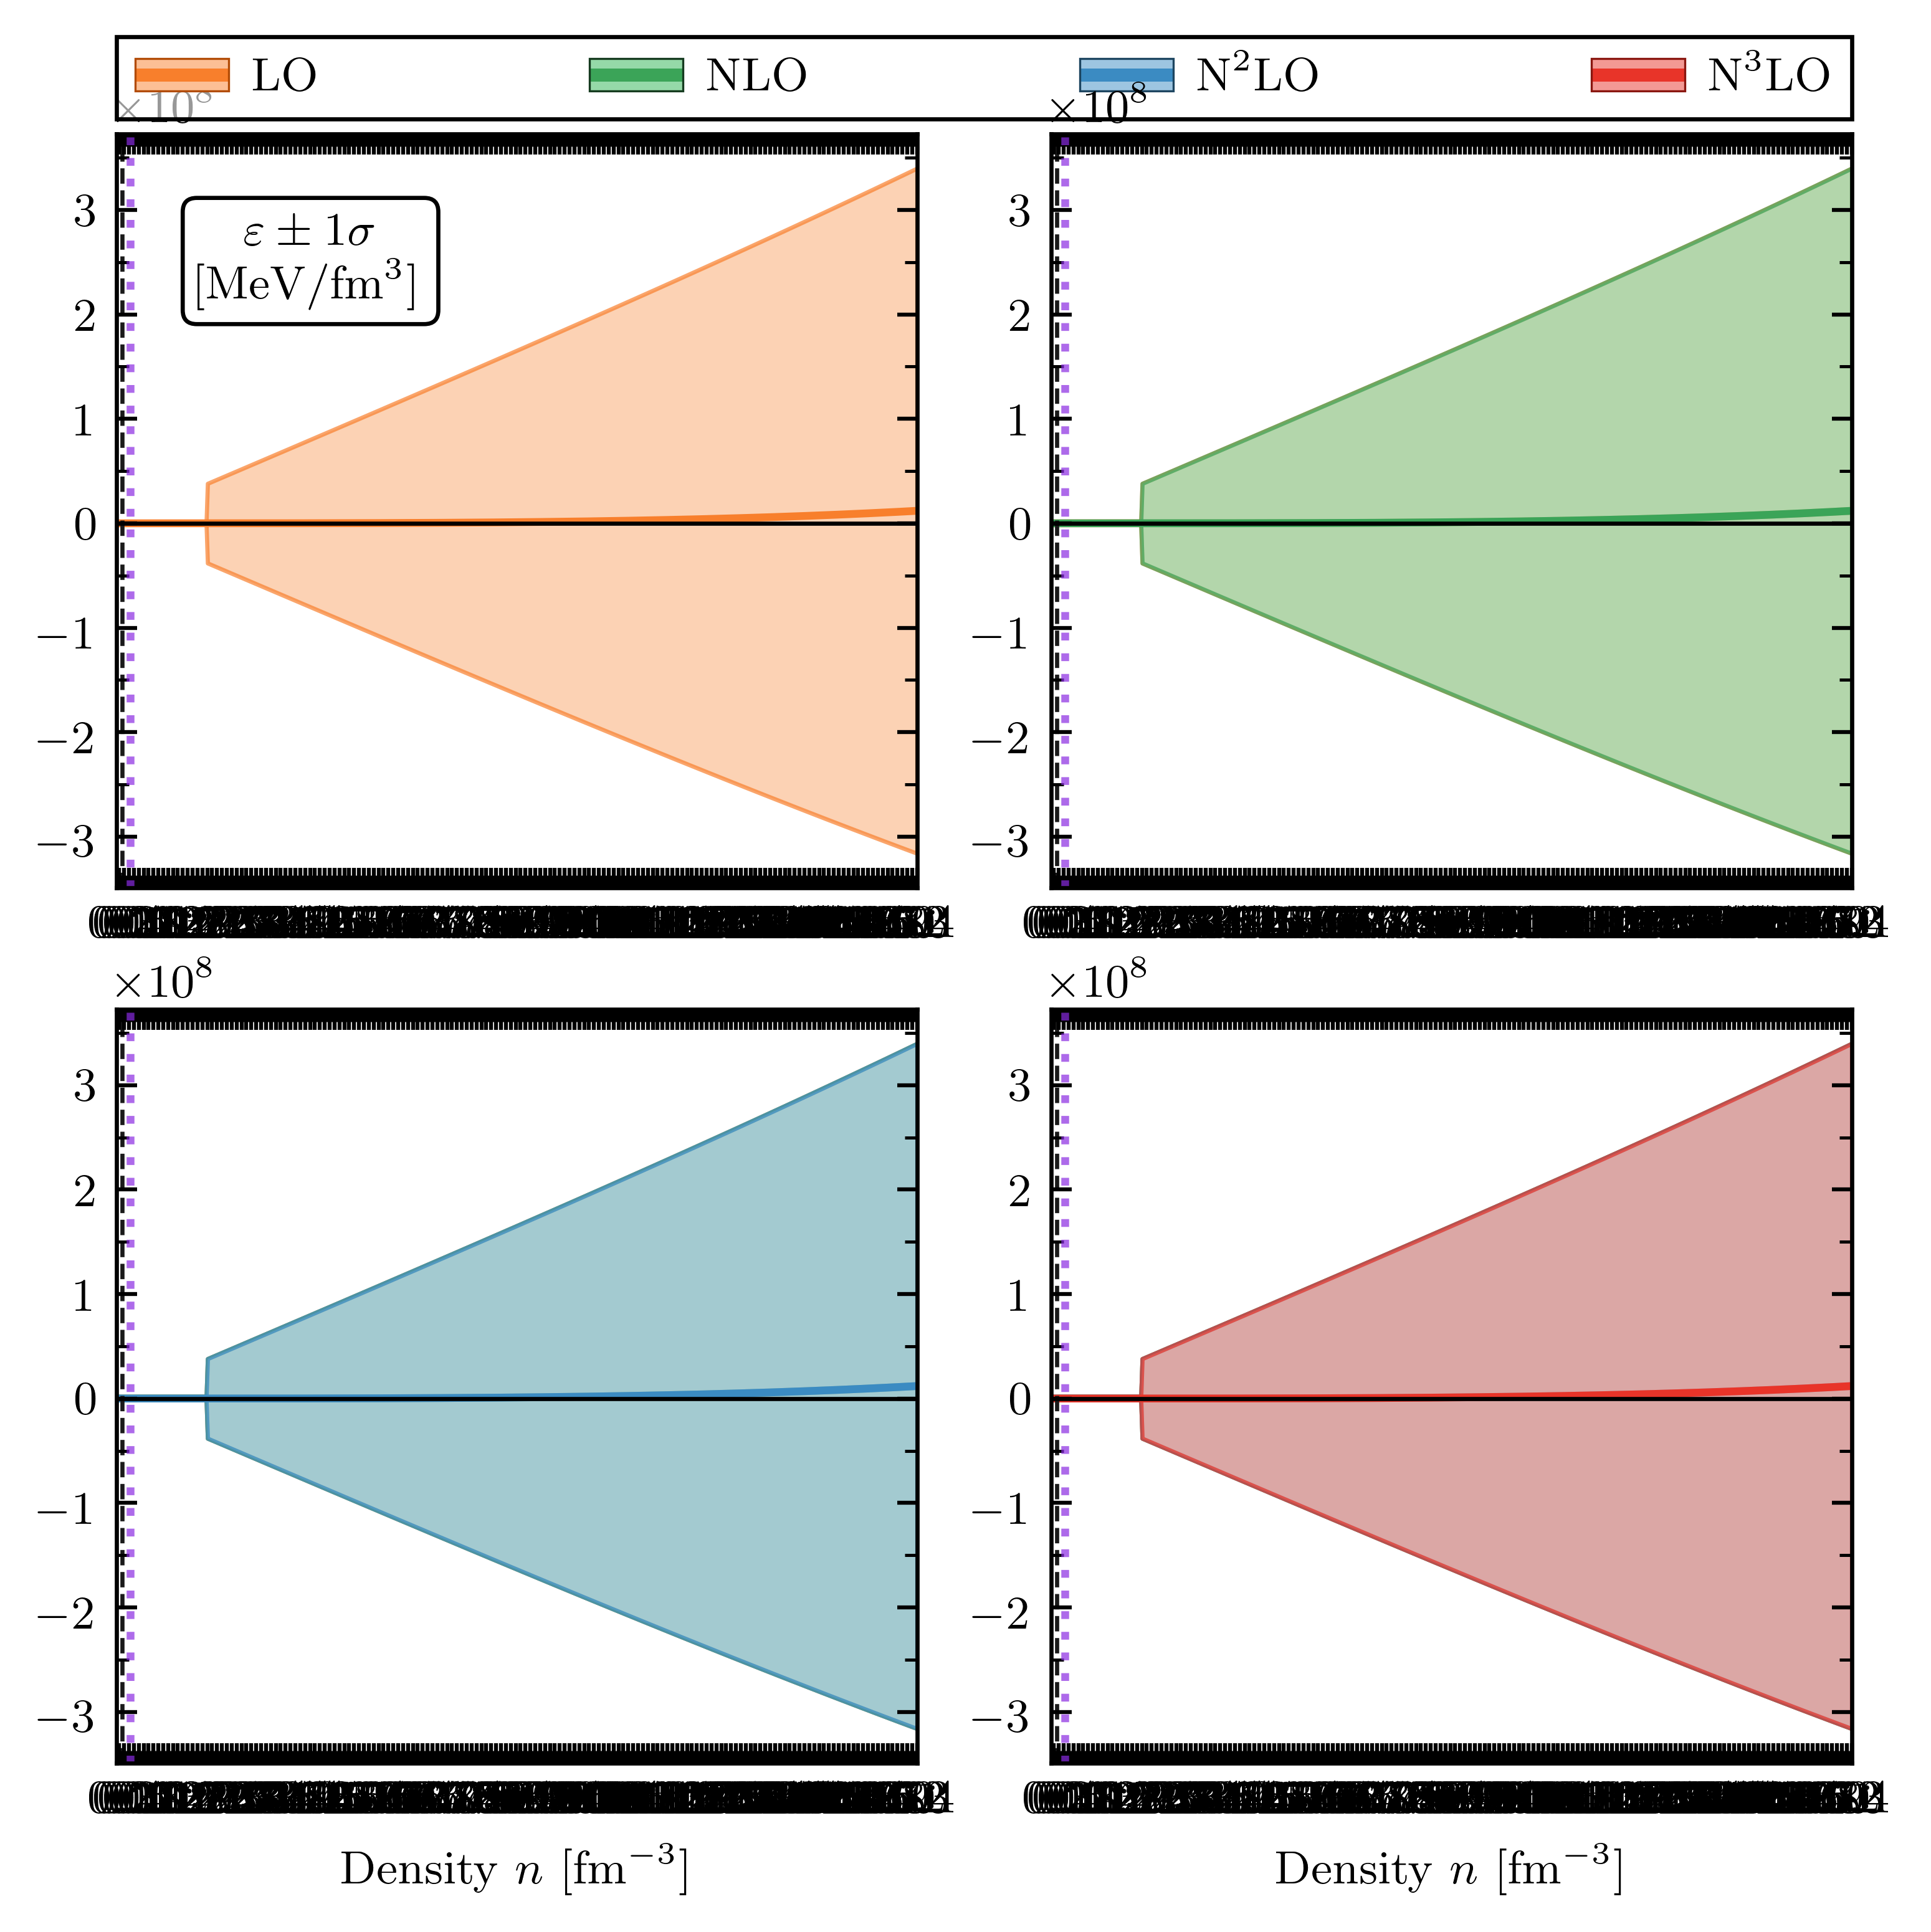

0.1591819699499165
[147.88671922 146.77638393 147.23200837 147.21613949]
[1.56903943 0.6866962  0.30053709 0.13153622]


In [42]:
# call the chiral function
energy_density_s, energy_density_s_stds = chiral.energy_dens(add_rest_mass=True)
    
# plot the energy density now wrt n 
fig, axes = plot_obs_panels(
    density_all, y=energy_density_s, dy=energy_density_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

for ax in axes.reshape(-1):
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

label = r"""$\varepsilon \pm 1\sigma$
[MeV/fm$^3$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

print(density_all[4])
print(energy_density_s[4])
print(energy_density_s_stds[4])

# save the energy density array to a file to interpolate later for points we need
#np.savez('../data/eos_data/edens_data_chiral.npz', density=density_all, mean=energy_density_s[:,3], std=energy_density_s_stds[:,3])

Now we want to get the result for $\mu(n)$. This can be done two different ways: by calculating the form from the thermodynamic identity, which includes terms we entirely possess,
$$
\mu(n) = \frac{P(n) + \varepsilon(n)}{n},
$$

or we can take the derivative of the energy density above,
$$
\mu(n) = \frac{\partial \varepsilon(n)}{\partial n} = n \frac{\partial(E/A)}{\partial n} + \frac{\varepsilon(n)}{n} = \frac{k_{F}}{3} \frac{\partial(E/A)}{\partial k_{F}} + \frac{\varepsilon(n)}{n}.
$$

Here $k_{F} = (3 \pi^{2} n/2)^{1/3}$. We'll compute both to check that we understand how this code operates.

In [38]:
# # compute the second equation above (derivative of energy density)
k_F = (3.0/2.0 * np.pi**2.0 * density_all)**(1.0/3.0)

Now we can plot both results of $\mu(n)$ and see if they are equal. 

mu(n) using the thermodynamic identity


/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


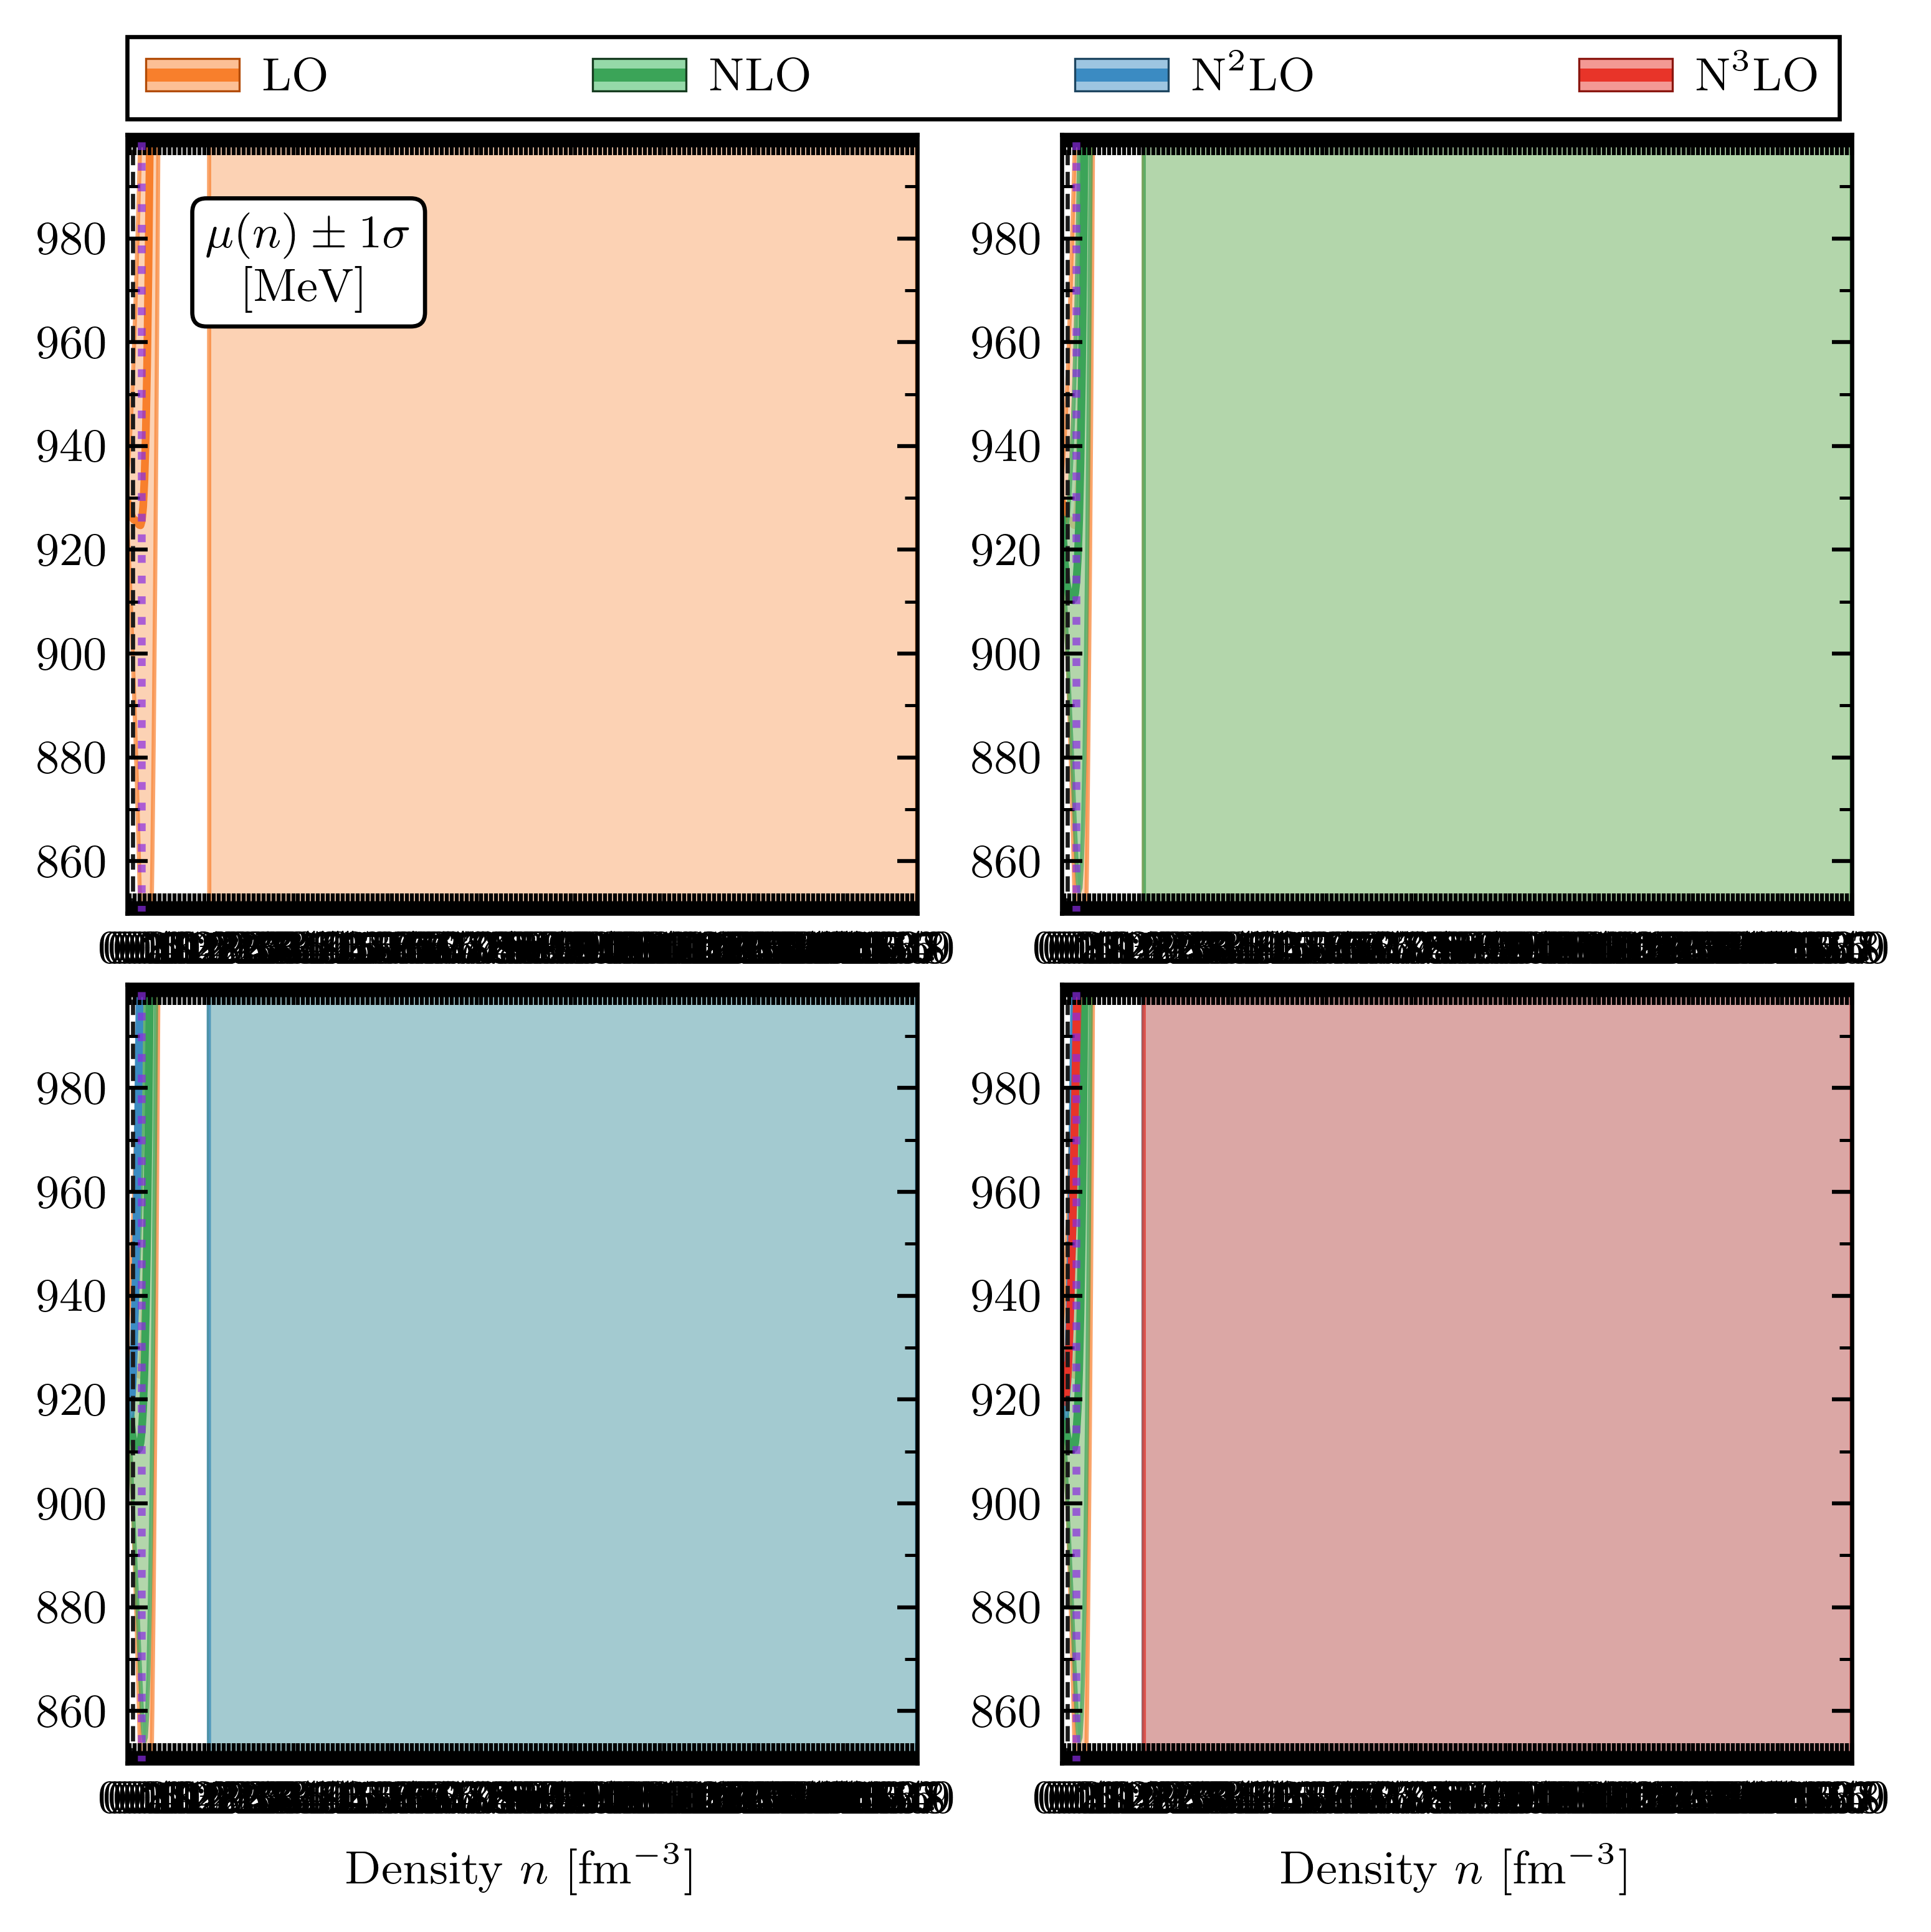

In [39]:
# plot mu(n) using thermodynamic identity
# call chiral function first
mu_s, mu_s_stds = chiral.chemical_potential(method=1, add_rest_mass=True)
fig, axes = plot_obs_panels(
    density_all, y=mu_s, dy=mu_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(850, 1000-1e-5)
axes[1, 0].set_ylim(850, 1000-1e-5)
axes[0, 1].set_ylim(850, 1000-1e-5)
axes[1, 1].set_ylim(850, 1000-1e-5)

for ax in axes.reshape(-1):
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

label = r"""$\mu(n) \pm 1\sigma$
[MeV]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
#fig.savefig(join(fig_path, f'energy_obs-s_panels_Lambda-{Lambda}'))
print('mu(n) using the thermodynamic identity')
plt.show()

mu(n) using the derivative of epsilon


/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


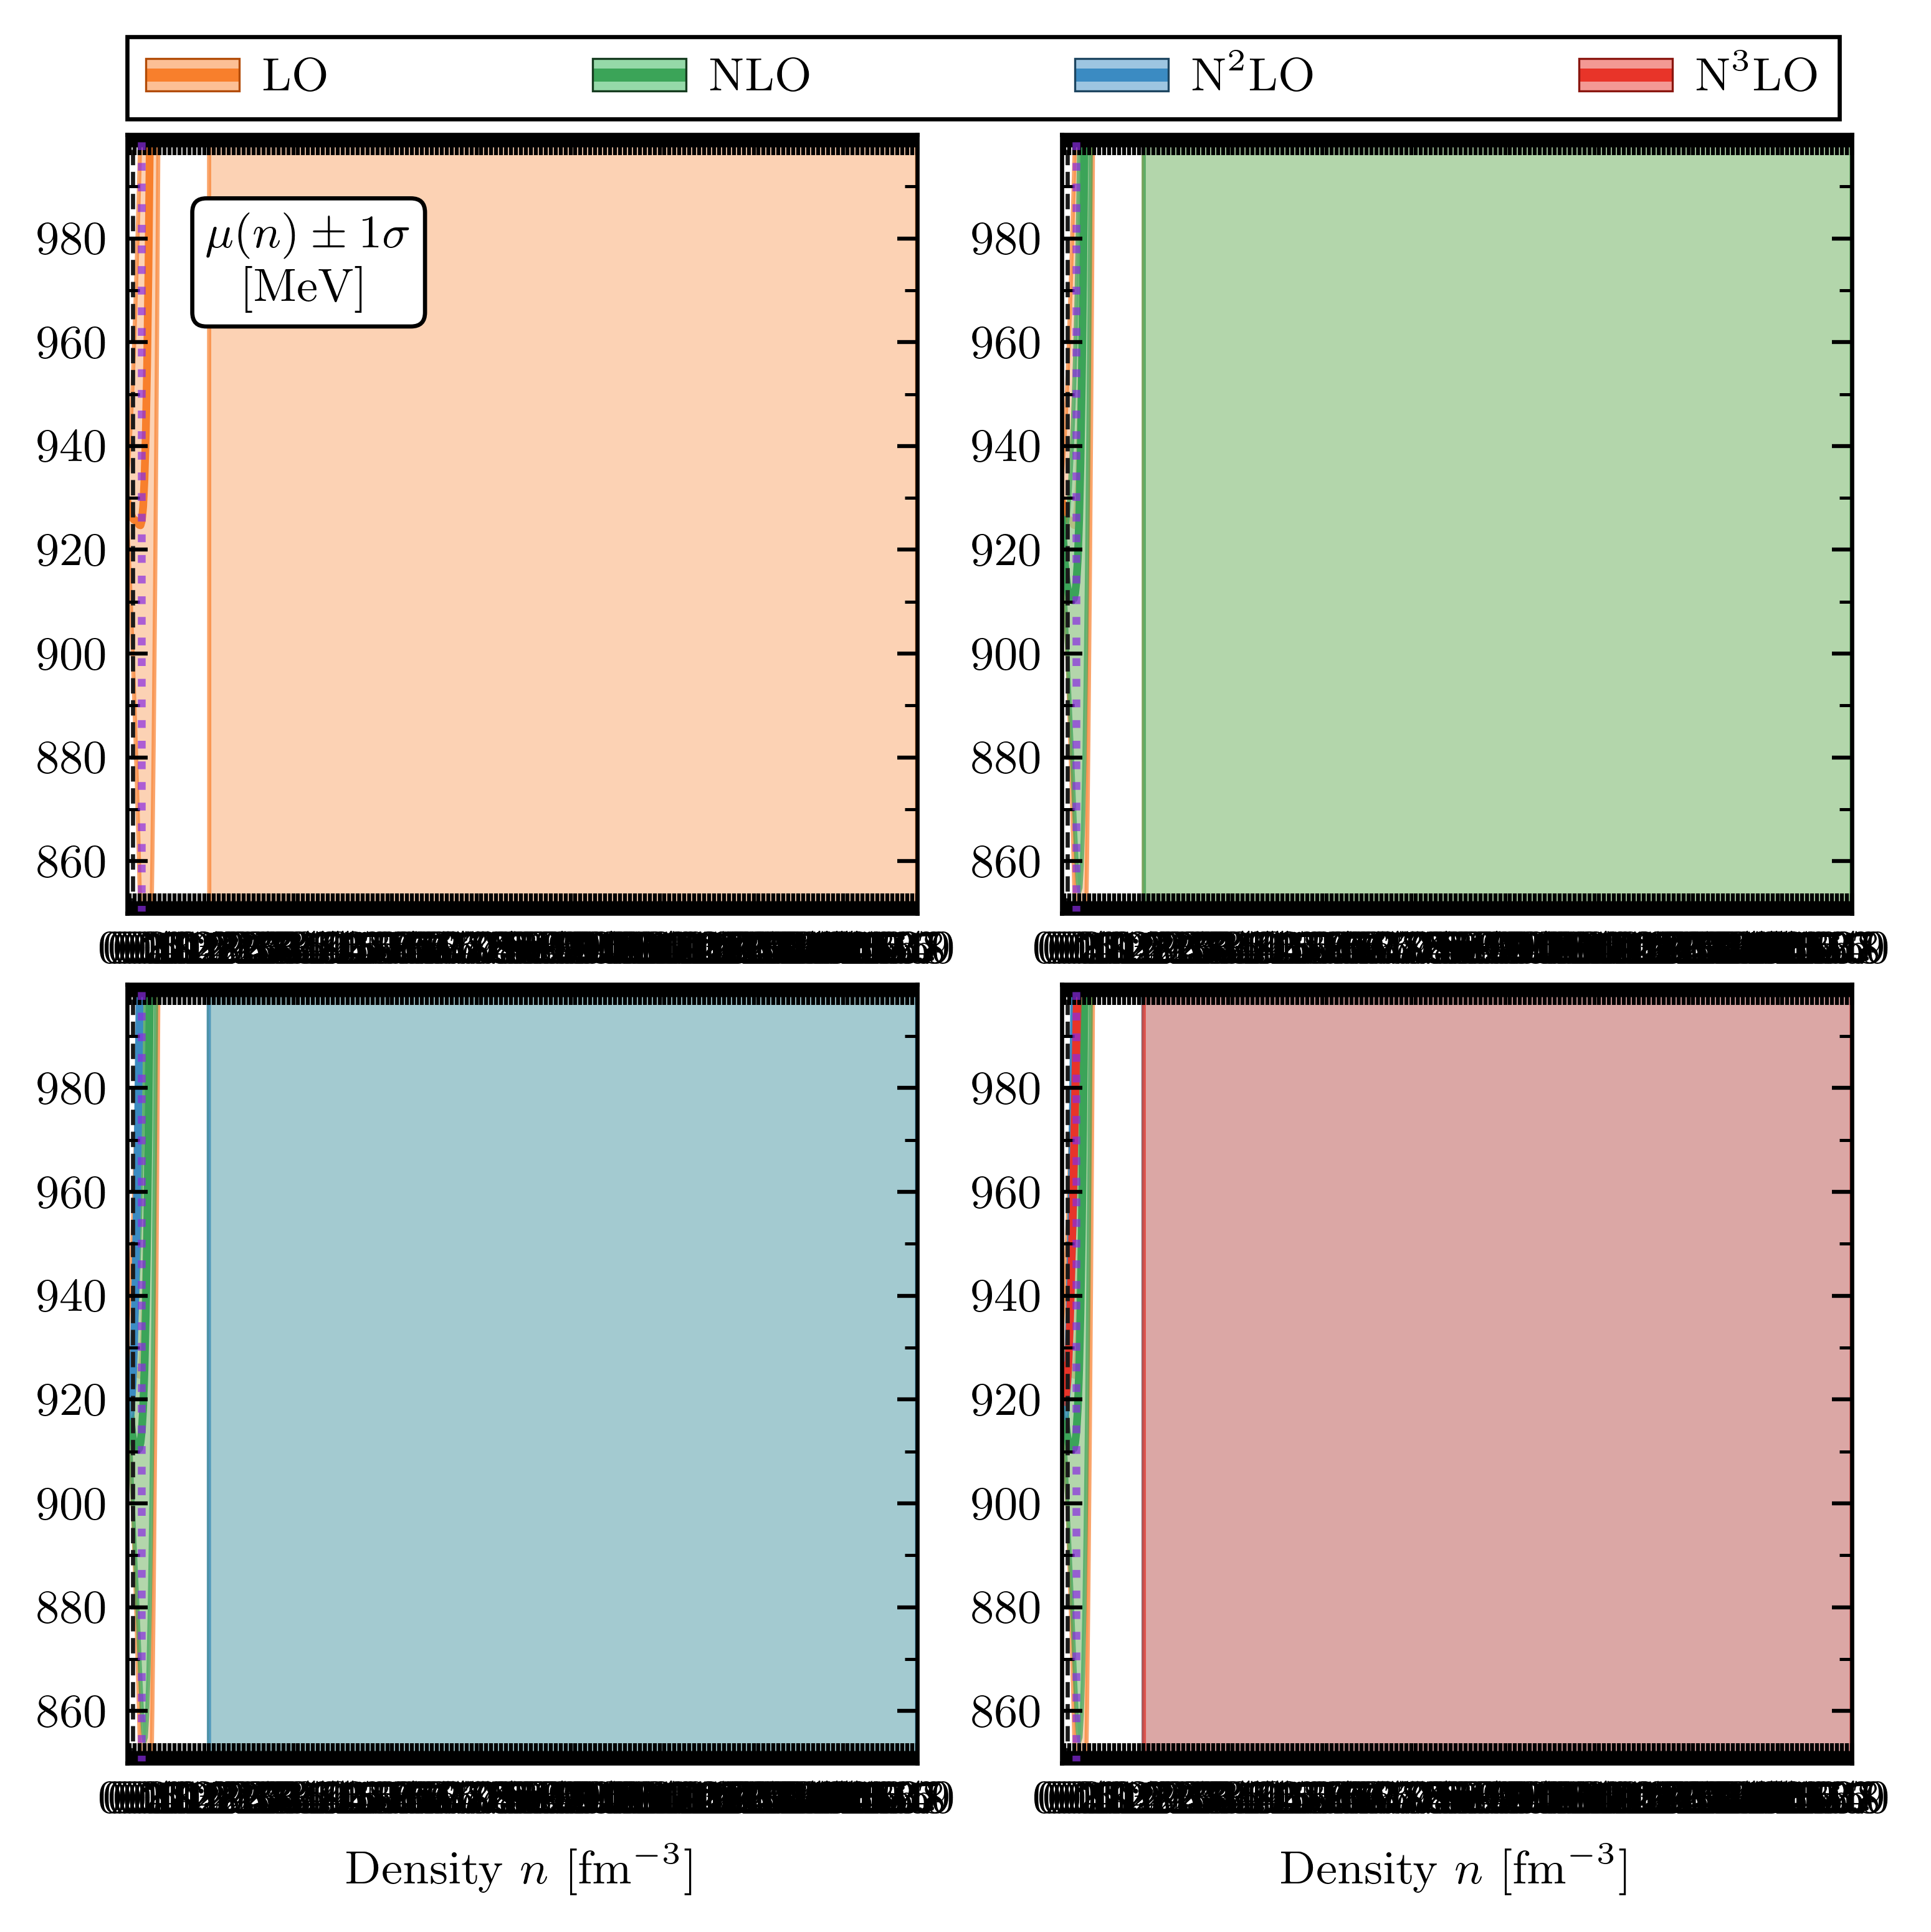

[[9.29355403e+02 9.25710719e+02 9.26742400e+02 9.26481423e+02]
 [9.28578664e+02 9.21688606e+02 9.23454017e+02 9.22825547e+02]
 [9.27757806e+02 9.18154756e+02 9.20920618e+02 9.20862263e+02]
 ...
 [2.39379681e+06 2.39379681e+06 2.39379681e+06 2.39379681e+06]
 [2.40388243e+06 2.40388243e+06 2.40388243e+06 2.40388243e+06]
 [2.41399351e+06 2.41399351e+06 2.41399351e+06 2.41399351e+06]]


In [40]:
# plot mu(n) using the derivative of eps
# first call chiral function
mu_s_deriv, mu_s_deriv_stds = chiral.chemical_potential(method=2, add_rest_mass=True)

fig, axes = plot_obs_panels(
    density_all, y=mu_s_deriv, dy=mu_s_deriv_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(850, 1000-1e-5)
axes[1, 0].set_ylim(850, 1000-1e-5)
axes[0, 1].set_ylim(850, 1000-1e-5)
axes[1, 1].set_ylim(850, 1000-1e-5)

for ax in axes.reshape(-1):
     ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

label = r"""$\mu(n) \pm 1\sigma$
[MeV]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
print('mu(n) using the derivative of epsilon')
plt.show()

print(chiral.mu_s)

## Speed of sound ($c_{s}^{2}$)

Now we want to calculate the speed of sound. This can be done via the simple relation

$$
c_{s}^{2} = \frac{n}{\mu}\frac{\partial \mu}{\partial n}.
$$

We know $n$ as our density array, and $\mu(n) \equiv \mu$ from our relation plotted above. We still need the derivative of $\mu(n)$ with respect to $n$. Since our GP results are with respect to $k_{F}$, it might be prudent to take the derivative and split it with respect to $k_{F}$, so that our results can have propagated uncertainties from the GP used for $E/A$. 

The equation for the chemical potential is

$$
\mu(n) = \frac{\partial \varepsilon(n)}{\partial n} = n \frac{\partial(E/A)}{\partial n} + \frac{\varepsilon(n)}{n} = \frac{k_{F}}{3} \frac{\partial(E/A)}{\partial k_{F}} + \frac{\varepsilon(n)}{n}.
$$

We can take the derivative of this, which yields

$$
\frac{\partial \mu(n)}{\partial n} = \frac{\partial}{\partial n} \left( \frac{k_{F}}{3} \frac{\partial(E/A)}{\partial k_{F}} + \frac{\varepsilon(n)}{n} \right),
$$

or we can take an alternate route with the calculation done before, recopied below.

\begin{align}
c_s^2 & = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n} \left[ \frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{\partial P}{\partial n} \left[ \frac{E}{A} + m + n \, \frac{\partial }{\partial n} \frac{E}{A} \right]^{-1} \\
\frac{\partial P}{\partial n} & = 2n \frac{d}{dn} \frac{E}{A} + n^2 \frac{d^2}{dn^2} \frac{E}{A}
\end{align}

Here, we know that $\frac{\partial \varepsilon(n)}{\partial n} \equiv \mu(n)$, so we don't have to do anything there except divide. The trickier piece is now $\frac{\partial P}{\partial n}$.

$$
c_{s}^{2} = \frac{\partial P}{\partial n} \mu(n)^{-1}.
$$

In [41]:
# check the difference to make sure everything is still OK
#print(mu_s - mu_s_deriv) # we're good!

$$
L(n) = 3\,n \, \frac{d}{dn} E_\text{sym}(n) = 3n \frac{dk_f}{dn} \frac{d}{dn} E_\text{sym}(n)
     = 3\,n \, \frac{k_f}{3n} \frac{d}{dk_f}  E_\text{sym}(n) = k_f \frac{d}{dk_f} E_\text{sym}(n)
$$

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_75247/530116177.py:18: RuntimeWarning: invalid value encountered in sqrt
  slope_std = np.sqrt(np.diag(slope_cov))
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


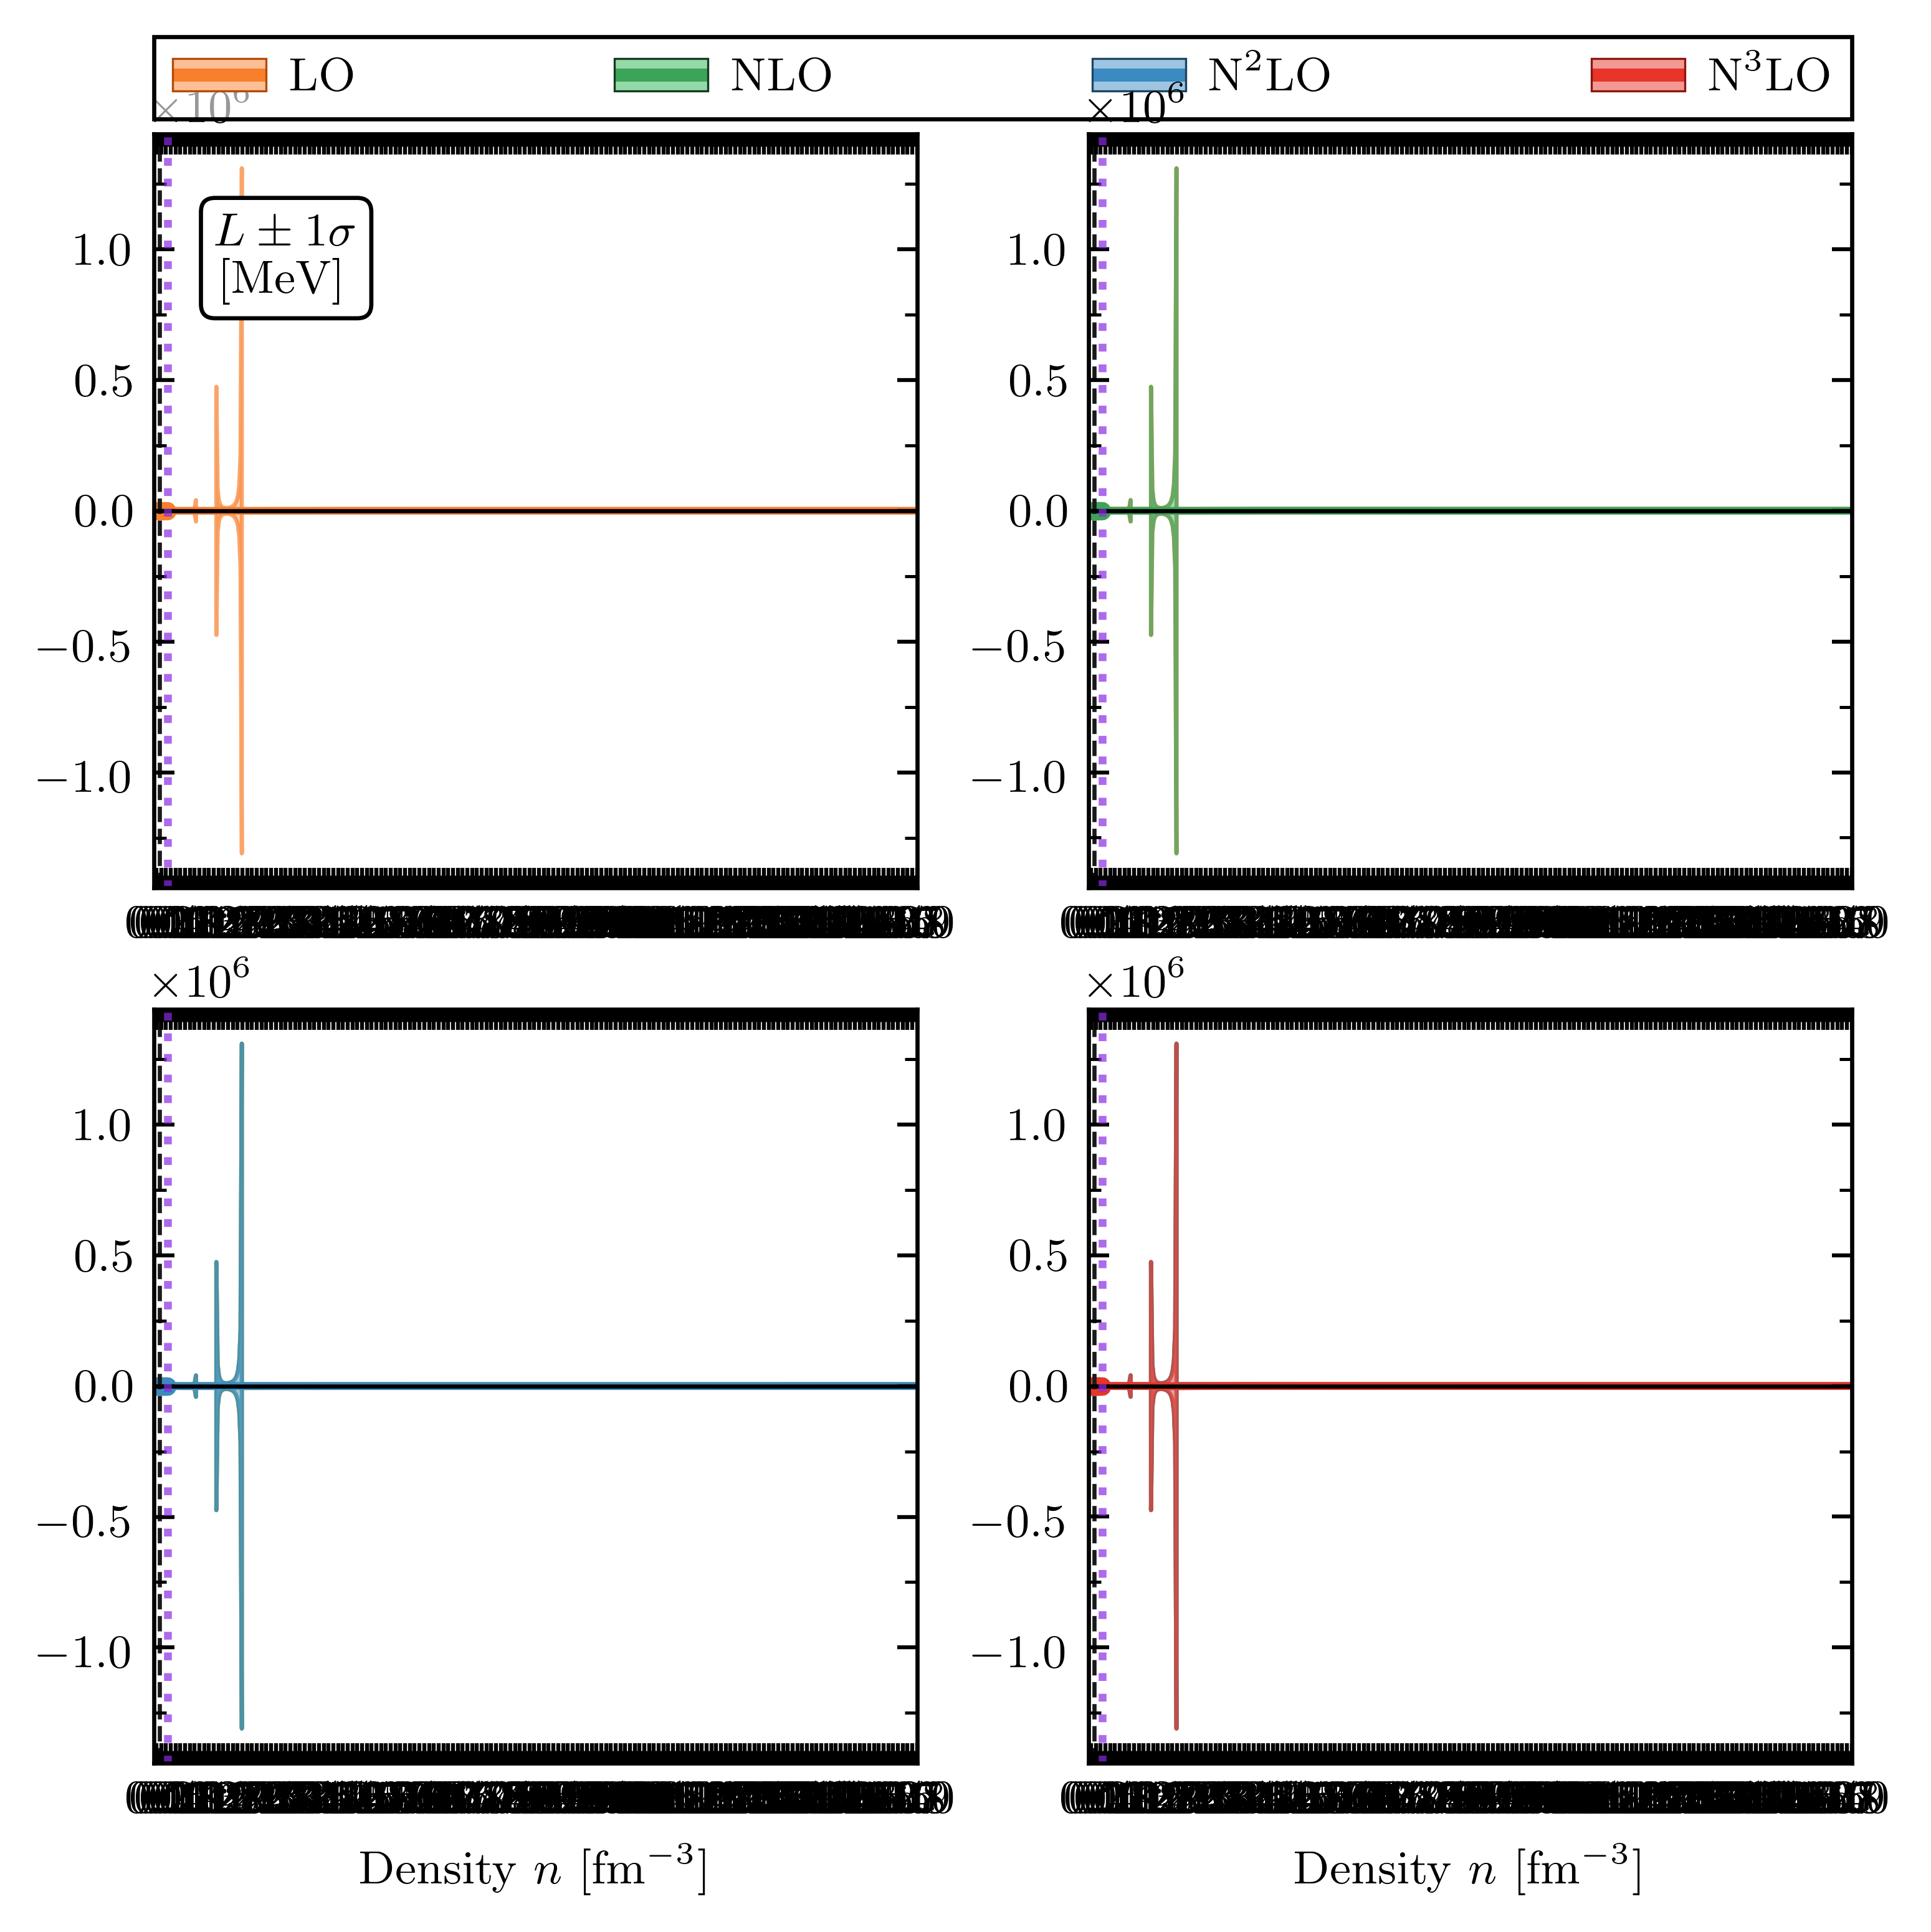

In [42]:
slopes = []
slope_stds = []
slope_fits = []

for i, n in enumerate(chiral.orders):
    slope = compute_slope(
        obs_sym_energy.density_interp,
        obs_sym_energy.kf_interp,
        dS2=obs_sym_energy.get_pred(order=n, deriv=1),
        wrt_kf=False
    )
    slope_cov = compute_slope_cov(
        obs_sym_energy.density_interp,
        obs_sym_energy.kf_interp,
        dS2_cov=obs_sym_energy.get_cov(order=n, deriv1=1, deriv2=1),
        wrt_kf=False
    )
    slope_std = np.sqrt(np.diag(slope_cov))

#     slope_alt_diff = compute_slope(
#         obs_sym_energy.density,
#         obs_sym_energy.kf,
#         dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=True)
#     )
#     slope_alt_diff = compute_slope(
#         obs_sym_energy.density,
#         obs_sym_energy.kf,
#         dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=False),
#         wrt_kf=False
#     )
    slope_alt_diff = compute_slope(
        obs_sym_energy.density,
        obs_sym_energy.kf,
        dS2=obs_sym_energy.poly_interp(order=n, deriv=1, wrt_kf=False),
        wrt_kf=False
    )
    
    slopes.append(slope)
    slope_stds.append(slope_std)
    slope_fits.append(slope_alt_diff)

slopes = np.array(slopes).T
slope_stds = np.array(slope_stds).T
slope_fits = np.array(slope_fits).T
    
fig, axes = plot_obs_panels(
    density_all, y=slopes, dy=slope_stds, orders=chiral.orders,
    density_data=chiral.density[::3], y_data=slope_fits[::3],
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

# axes[0, 0].set_ylim(-1000-1e-3, 1000)
# axes[1, 0].set_ylim(-1000, 1000-1e-3)
for ax in axes.reshape(-1):
   # ax.set_xlim(0.05, 3.2)
   # ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)
label = r"""$L \pm 1\sigma$
[MeV]"""
# for ax in axes.ravel():
#     ax.yaxis.set_major_locator(MultipleLocator(25))
axes[0, 0].text(
    0.08, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)

#fig.savefig(join(fig_path, f'slope_panels_Lambda-{Lambda}'))
plt.show()

__Note__: The break within the symmetry energy container due to the NaN values is very evident here. We need to determine what to do in those regions---they're obviously outside of our region of care wrt chiral EFT's validity--> set them to positive values?

<!-- $$ 
K(n) = 9 \, n^2 \frac{d}{dn} \frac{E}{A} = 9 \, n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = 9 \, n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = 3 \, n \, k_f \frac{d}{dk_f}  \frac{E}{A}
$$ -->

\begin{align}
    K(n) = 9 n^2 \frac{d^2}{dn^2} \frac{E}{A} = 9 n^2 \left[\frac{d^2k_f}{dn^2} \left(\frac{d}{dk_f} \frac{E}{A}\right) + \left(\frac{dk_f}{dn}\right)^2 \frac{d^2}{dk_f^2} \frac{E}{A} \right]
\end{align}

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


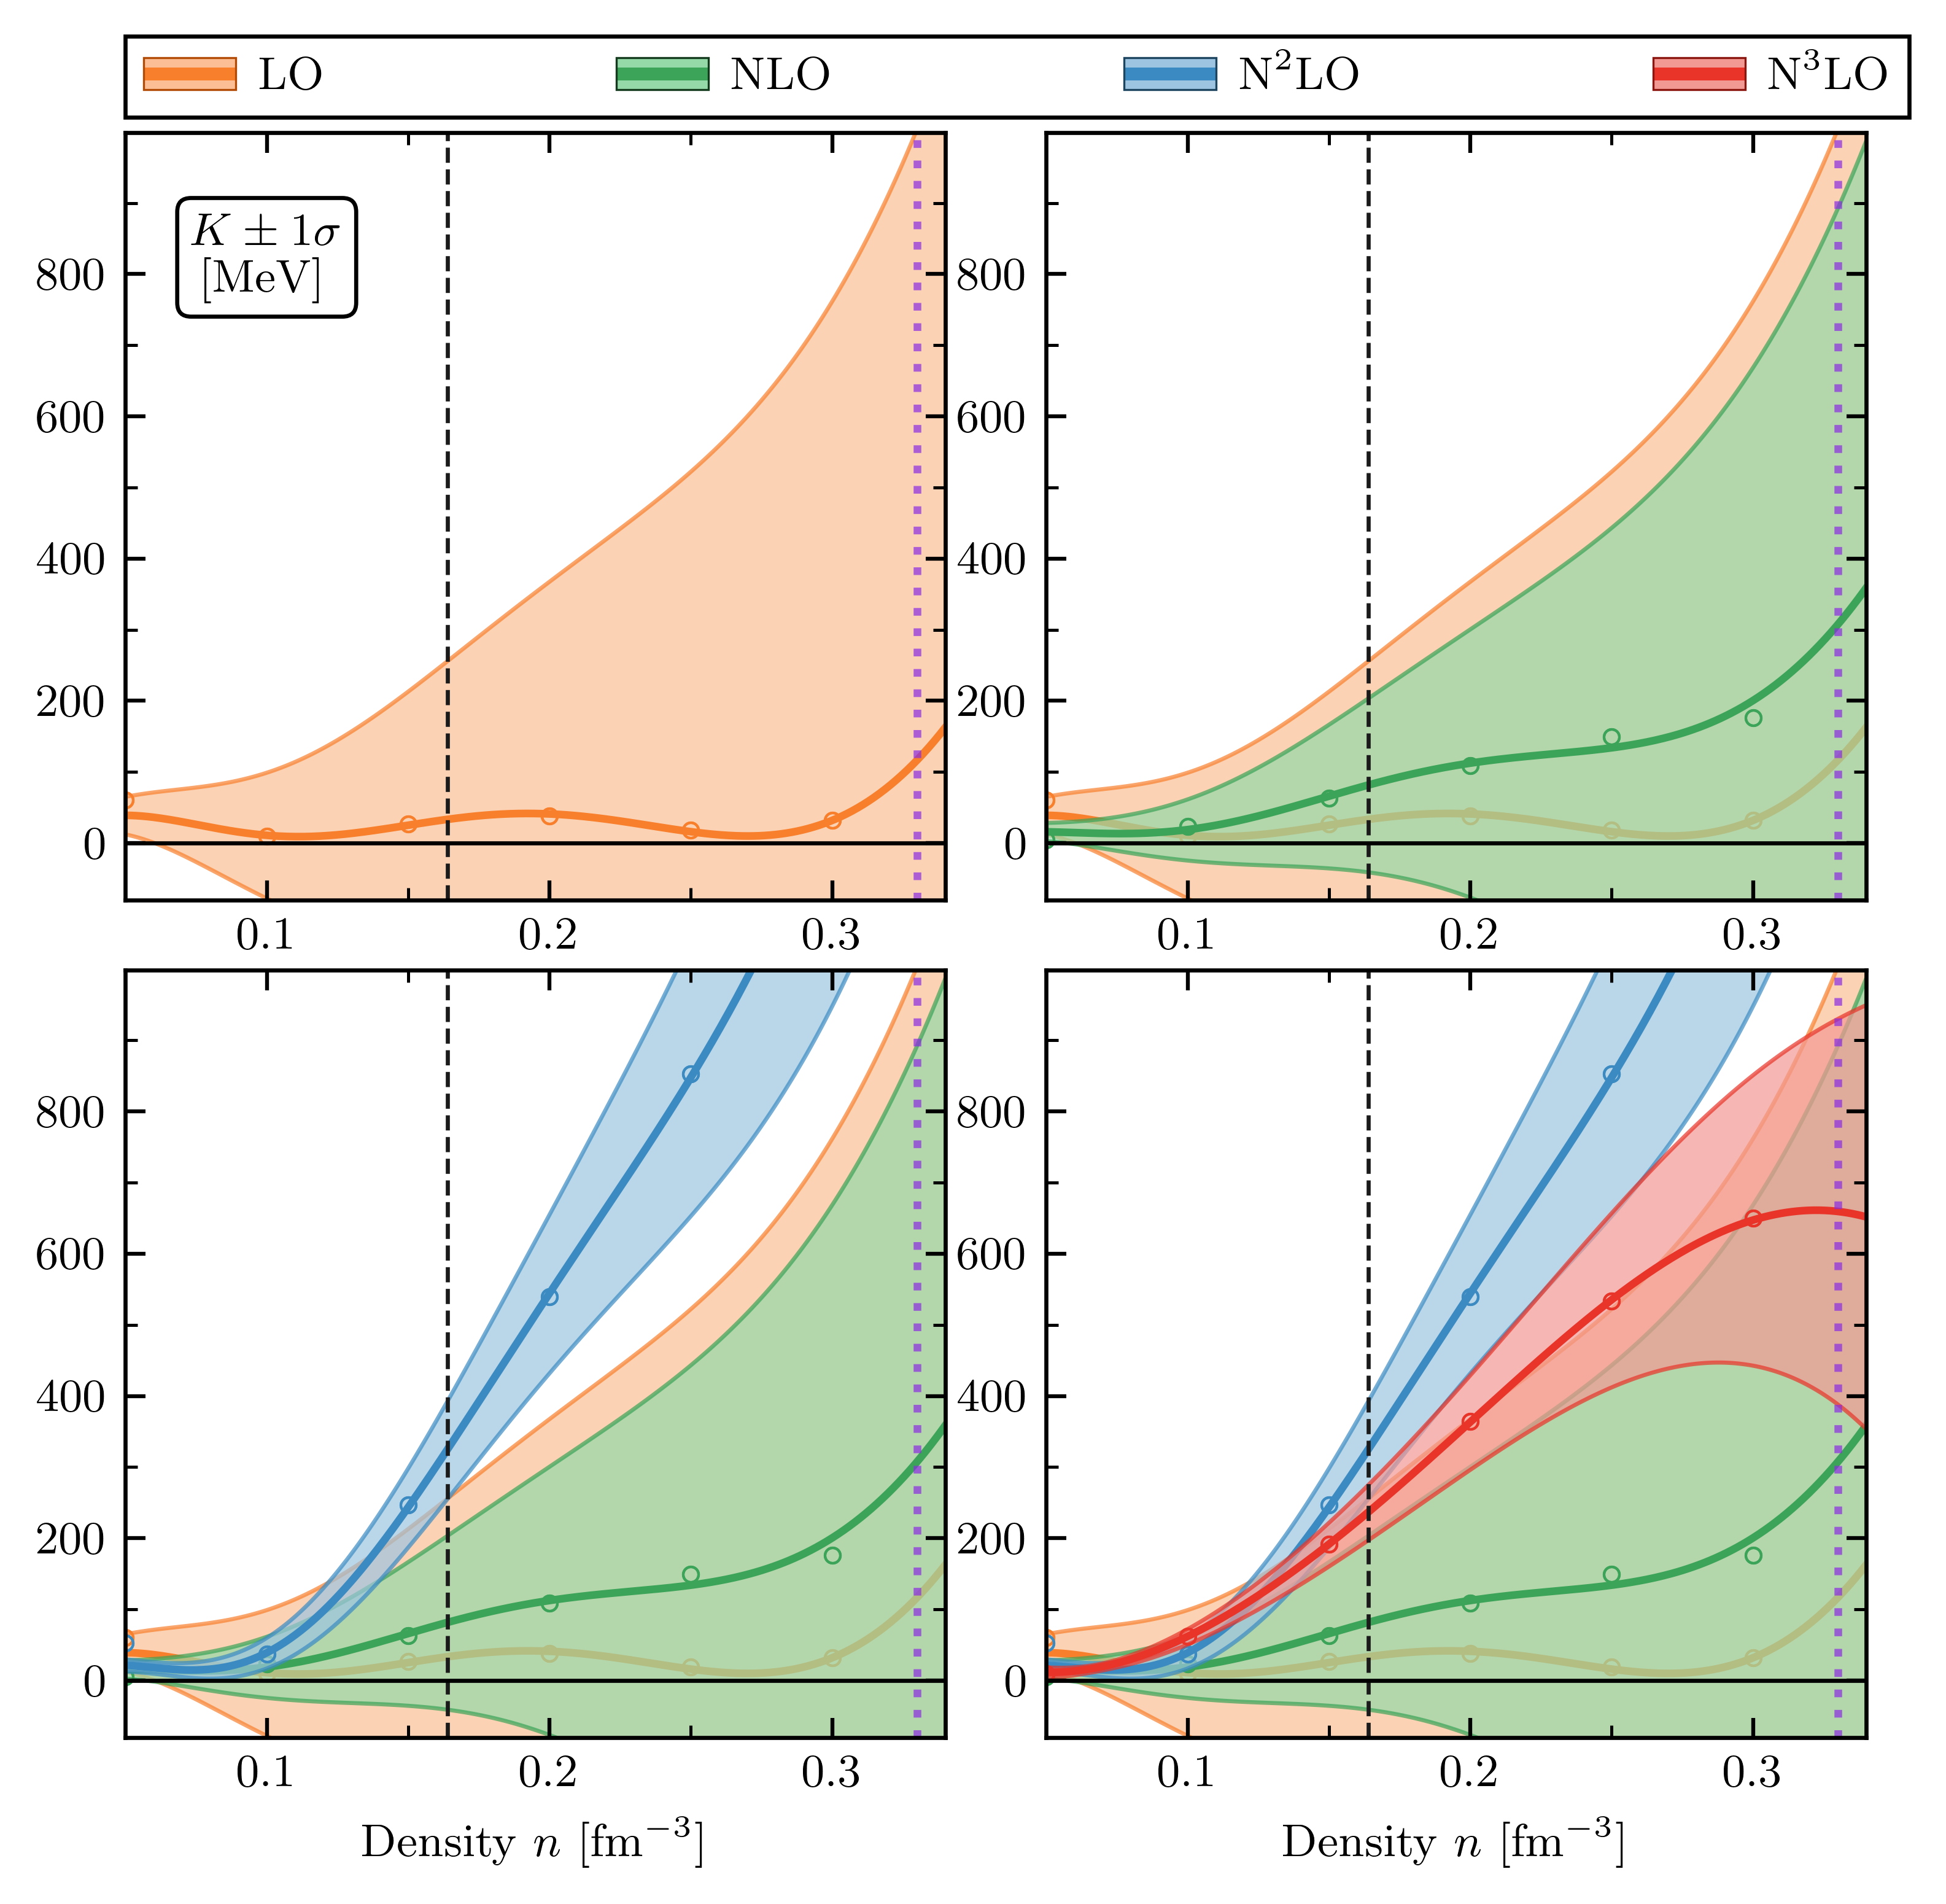

In [61]:
K_incomps = []
K_incomp_stds = []
K_incomp_fits = []

for i, n in enumerate(chiral.orders):
    K_incomp = compute_compressibility(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        d2E=obs_nuclear.get_pred(order=n, deriv=2),
        dE=obs_nuclear.get_pred(order=n, deriv=1),
    )
    K_incomp_cov = compute_compressibility_cov(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        d2E_cov=obs_nuclear.get_cov(order=n, deriv1=2, deriv2=2),
        dE_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1),
        dE_d2E_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=2),
    )
    K_incomp_std = np.sqrt(np.diag(K_incomp_cov))

    # Derivative wrt kf and n differ!
#     K_incomp_alt_diff = compute_compressibility(
#         obs_neutron.density,
#         obs_neutron.kf,
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=True),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True),
#     )
#     K_incomp_alt_diff = compute_compressibility(
#         obs_neutron.density,
#         obs_neutron.kf,
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=False),
#         wrt_kf=False
#     )
    K_incomp_alt_diff = compute_compressibility(
        obs_nuclear.density,
        obs_nuclear.kf,
        d2E=obs_nuclear.poly_interp(order=n, deriv=2, wrt_kf=False),
#         d2E=obs_nuclear.spline(obs_nuclear.density, order=n, deriv=2),
        wrt_kf=False
    )
    
    K_incomps.append(K_incomp)
    K_incomp_stds.append(K_incomp_std)
    K_incomp_fits.append(K_incomp_alt_diff)

    
K_incomps = np.array(K_incomps).T
K_incomp_stds = np.array(K_incomp_stds).T
K_incomp_fits = np.array(K_incomp_fits).T
    
fig, axes = plot_obs_panels(
    density_all, y=K_incomps, dy=K_incomp_stds, orders=chiral.orders,
    density_data=chiral.density[::5], y_data=K_incomp_fits[::5],
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(-80, 999)
axes[1, 0].set_ylim(-80, 999)
axes[0, 1].set_ylim(-80, 999)
axes[1, 1].set_ylim(-80, 999)
# axes[0, 0].set_ylim(-1000-1e-3, 1000)
# axes[1, 0].set_ylim(-1000, 1000-1e-3)
for ax in axes.reshape(-1):
#     ax.set_xlim(0.05, 3.2)
#     ax.set_xticks([0.1, 0.7, 1.3, 1.9, 2.5, 3.1])
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)
label = r"""$K \pm 1\sigma$
[MeV]"""
axes[0, 0].text(
    0.08, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
#fig.savefig(join(fig_path, f'incomp_sym_panels_Lambda-{Lambda}'))
plt.show()
    
# axes[0,0].set_ylabel('Compressibility $K$')
# axes[1,0].set_ylabel('Compressibility $K$')
# axes[0,0].set_xlabel('')
# axes[0,1].set_xlabel('');

## Calculating $c_{s}^{2}$ for SNM (or, how to do it completely wrong)

\begin{align}
c_S^2 & = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n} \left[ \frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{\partial P}{\partial n} \left[ \frac{E}{A} + m + n \, \frac{\partial }{\partial n} \frac{E}{A} \right]^{-1} \\
\frac{\partial P}{\partial n} & = 2n \frac{d}{dn} \frac{E}{A} + n^2 \frac{d^2}{dn^2} \frac{E}{A}
\end{align}

Here, the energy density $\varepsilon = n \left( \frac{E}{A} + m \right)$ includes the rest-mass contribution, so $\frac{E}{A}$ above does not.

We could attempt to just use 

$$
c_{s}^{2} = \frac{n}{\mu} \frac{\partial \mu}{\partial n},
$$

but we have to be aware of the rest mass there.

In [62]:
# set up the speed of sound
# dpdn_one = np.zeros([len(density_all), 4])
# dpdn_two = np.zeros([len(density_all), 4])
# dE = np.zeros([len(density_all), 4])
# dE_cov = []
# dE_std = []

# depsdn = mu_s   # includes the rest mass
# for i, n in enumerate(chiral.orders):
#     dE[:,i] = chiral.obs_nuclear.get_pred(order=n, deriv=1)
#     dE_cov.append(chiral.obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1))

# # cut the cov matrix to stds
# for i,n in enumerate(chiral.orders):
#     dE_std.append(np.sqrt(np.diag(dE_cov[i])))

# # convert to array to reshape
# dE_stds = np.asarray(dE_std).T

# for i in range(4):
#     dpdn_one[:,i] = 2 * (k_F * dE[:,i])/3.0
    
# # put it together
# cs2 = (dpdn_one + K_incomps/9.0) / depsdn
# cs2_stds = (dE_stds + K_incomp_stds/9.0) / mu_s_stds # definitely not correct; fix this

## Sampling $c_{s}^{2}$ (or, how to do it better)

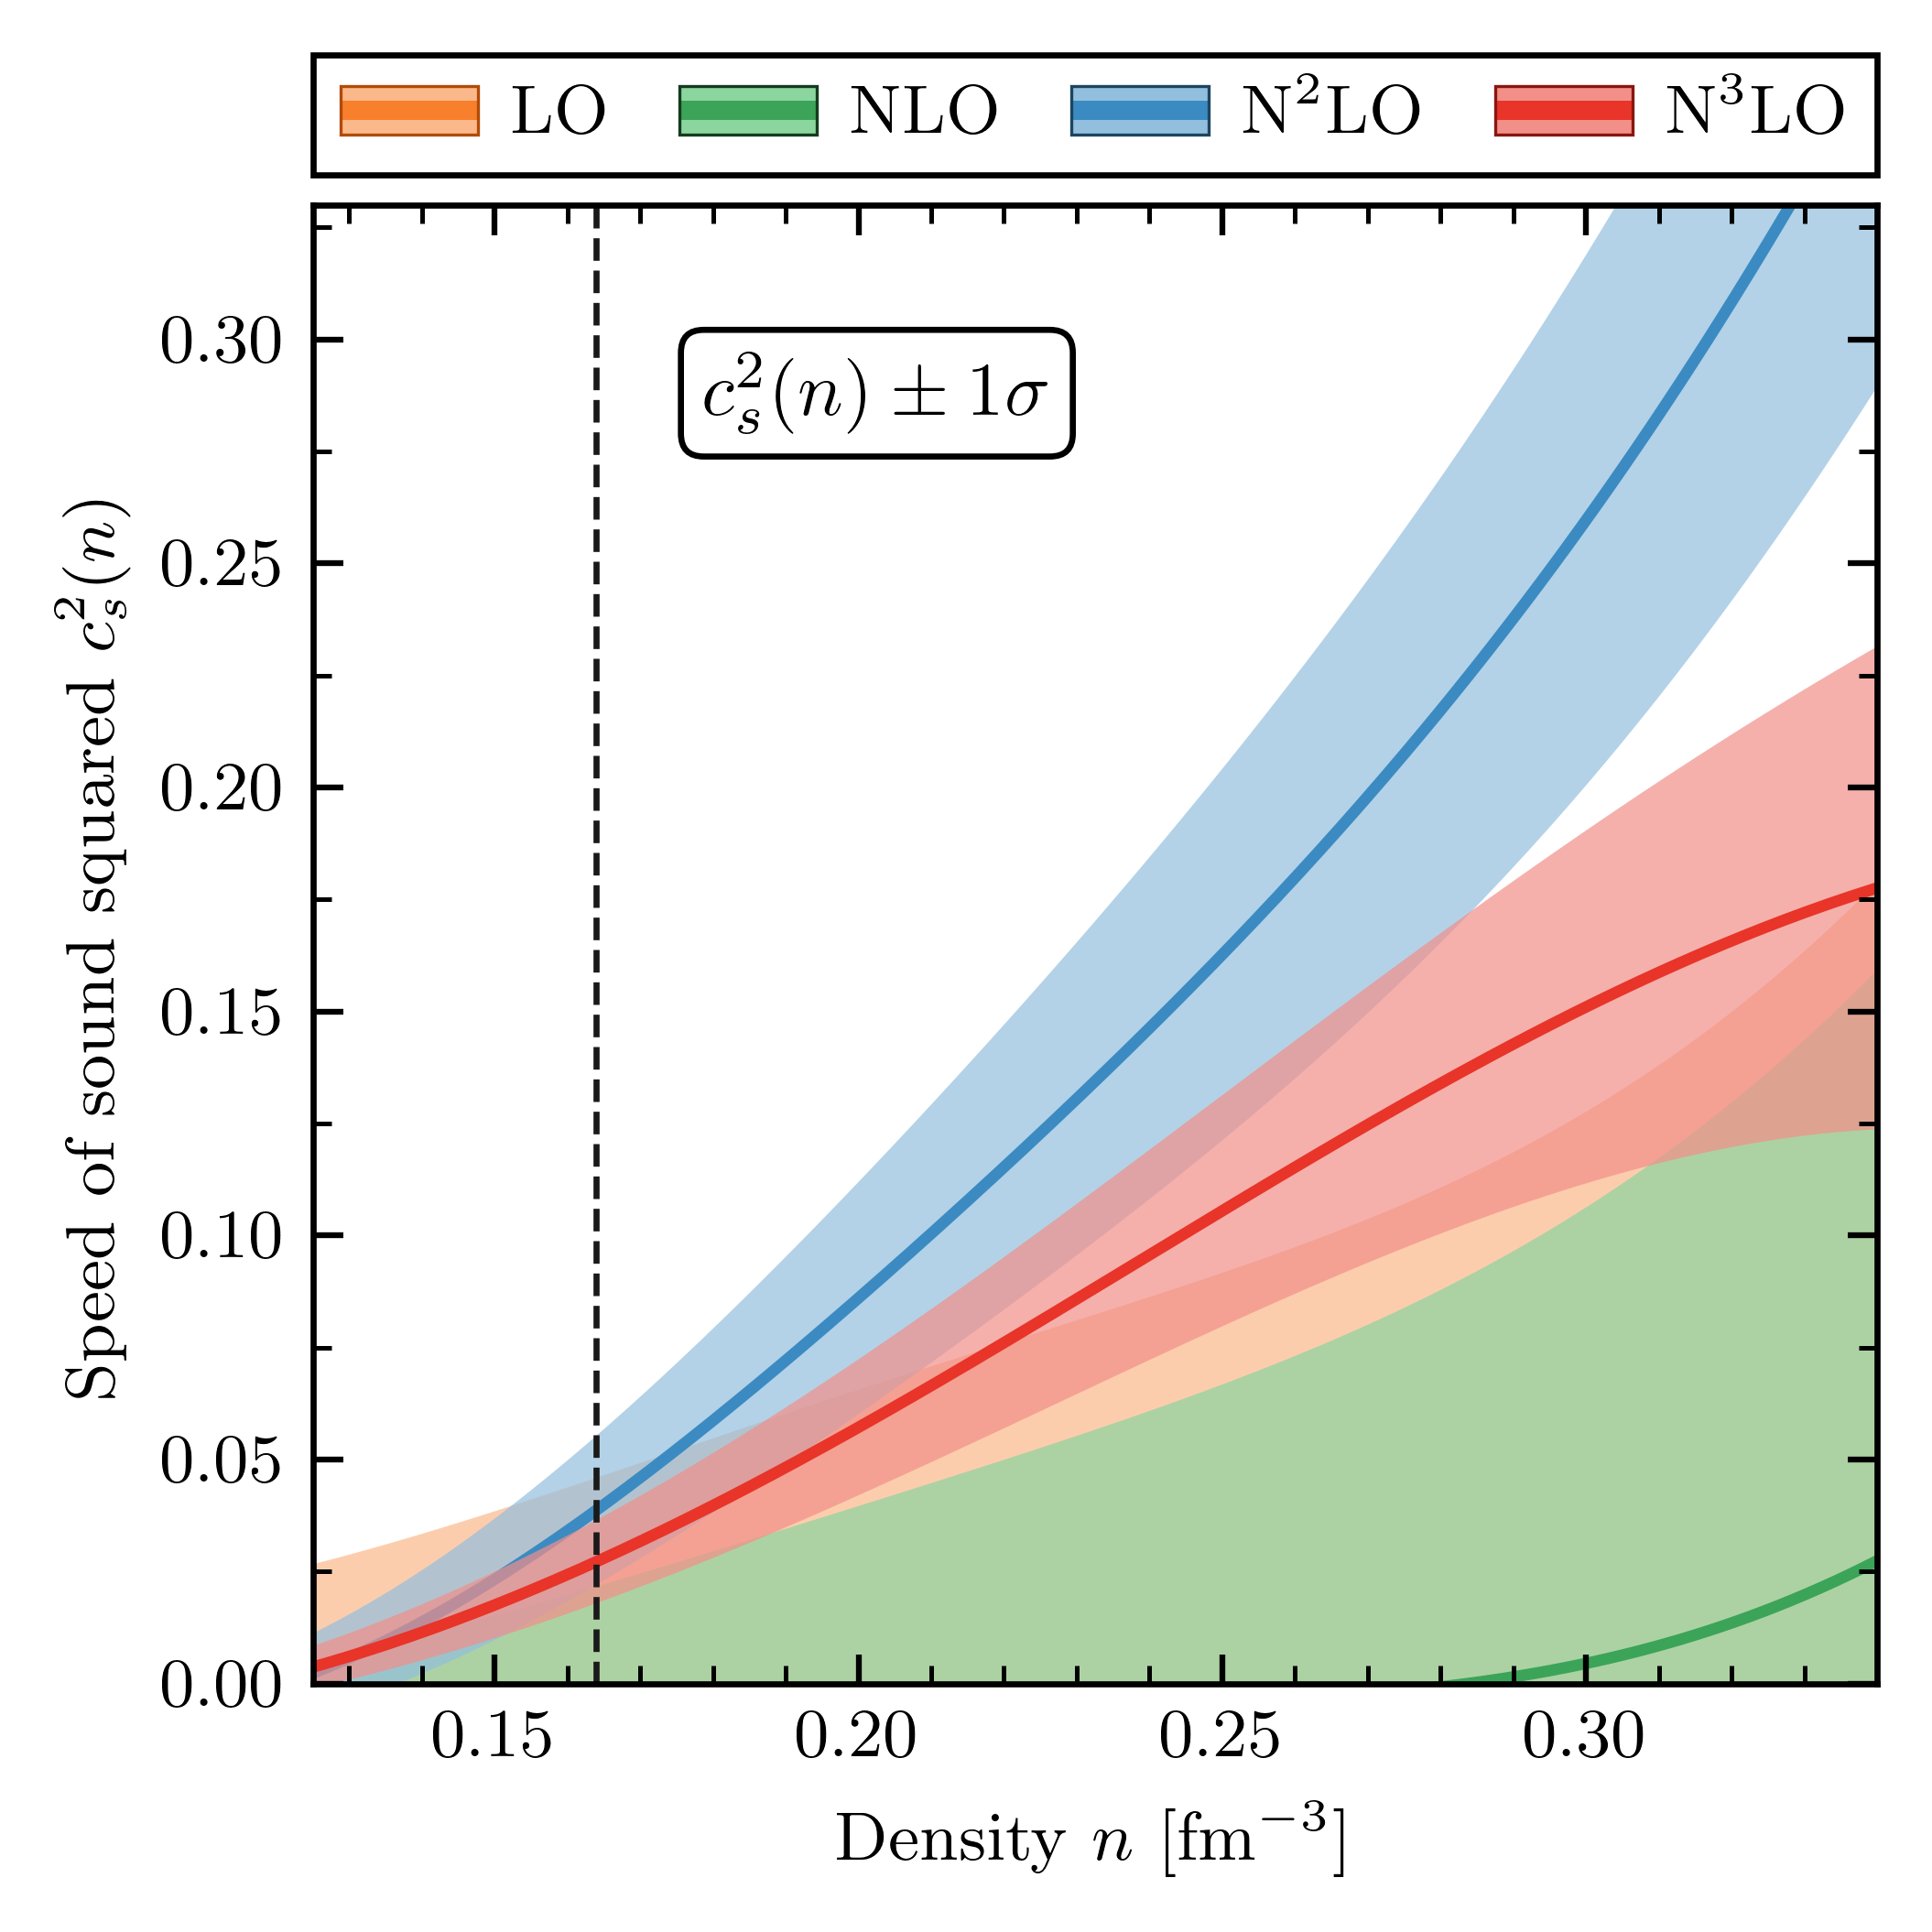

In [66]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter.matter import mass_neutron, mass_proton
mass_nucleon = (mass_neutron + mass_proton)/2.0
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

speed_of_sounds = []
speed_of_sound_stds = []
for i, n in enumerate(chiral.orders):
    E_per_A_samples_n = obs_nuclear.draw_sample(order=n, num_samp=500)
    speed_of_sound_samples = compute_speed_of_sound(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        E=E_per_A_samples_n[0].T,
        dE=E_per_A_samples_n[1].T,
        d2E=E_per_A_samples_n[2].T,
        mass=mass_nucleon
    )
    speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    speed_of_sounds.append(speed_of_sound_mean)
    speed_of_sound_stds.append(speed_of_sound_std)
    
    plot_obs_vs_density(
        density_all,
        speed_of_sound_mean,
        speed_of_sound_std,
        ax=ax,
        color_68=light_colors[i],
        c=colors[i],
        edgecolor=None,
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
        fillstyle='none',
        markeredgewidth=0.5,
    )
    
speed_of_sounds = np.array(speed_of_sounds).T
speed_of_sound_stds = np.array(speed_of_sound_stds).T
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylim(0.0, 0.33)
ax.set_xlim(0.125,0.34)
ax.tick_params(right=True, top=True, which='both')
label = r"""$c_{s}^{2}(n) \pm 1\sigma$"""
ax.text(
    0.25, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.set_ylabel(r'Speed of sound squared $c_{s}^{2}(n)$')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
#fig.savefig('cs2_n_2n0.PNG')
plt.show()

# save the data to an npz file to be used later for BMM
# if density_all[-1] <= 0.34:
#     np.savez('data/eos_data/speedofsoundchiral.npz', density=chiral.density_all, mean=speed_of_sounds, std=speed_of_sound_stds)
#     npzfile_cs2 = np.load('speedofsoundchiral.npz')
#     npzfile_cs2.files
# else:
#     print('Not saved.')

Notebook adapted from derivatives-bands.ipynb in https://github.com/buqeye/nuclear-matter-convergence repository.

Alexandra Semposki, 28 March 2024